In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

zone = 0

#nevents = 200000
nevents = -1

# Input files
signal = 'signal_add.1.npz'
bkgnd = 'bkgnd_add.1.npz'

# Image format
num_channels = 3
num_cols = 300
num_rows = 10
image_format = (num_rows, num_cols, num_channels)

# Parameter
num_pars = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49277655, -0.24515343, -0.06501561, 0.06501561, 0.24515343, 0.49277655])
  dzero_bins = np.array([-149.01635796, -80.24550629, -19.69444885, 19.69444885, 80.24550629, 149.01635796])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49370697, -0.26011642, -0.07240327, 0.07240327, 0.26011642, 0.49370697])
  dzero_bins = np.array([-148.42751366, -75.90176582, -18.08490837, 18.08490837, 75.90176582, 148.42751366])
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

# Labels
zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

logger.info('Processing zone {0}'.format(zone))
logger.info('.. nevents      : {0}'.format(nevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. pref_row     : {0}'.format(pref_row))
logger.info('.. invpt_bins   : {0}'.format(invpt_bins))
logger.info('.. dzero_bins   : {0}'.format(dzero_bins))

[INFO    ] Processing zone 0
[INFO    ] .. nevents      : -1
[INFO    ] .. image_format : (10, 300, 3)
[INFO    ] .. pref_row     : 4
[INFO    ] .. invpt_bins   : [-0.49277655 -0.24515343 -0.06501561  0.06501561  0.24515343  0.49277655]
[INFO    ] .. dzero_bins   : [-149.01635796  -80.24550629  -19.69444885   19.69444885   80.24550629
  149.01635796]


In [4]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def find_par_row_col(par):
  if par.ndim == 1:
    (invpt, d0, eta, phi, invpt2) = par
  else:
    (invpt, d0, eta, phi, invpt2) = np.split(par, np.array([1,2,3,4]), axis=1)
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

In [5]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, ax=None, cmap=None, vmin=None, vmax=None, colorbar=False):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=vmin, vmax=vmax)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges)
  return h, edges, patches

### Load data

In [6]:
def load_signal(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_aux = loaded['out_aux']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_aux: {0} out_hits: {1}'.format(out_aux.shape, out_hits.shape))
  return (out_aux, out_hits)

In [7]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
aux_arrays, bkghits_arrays = load_bkgnd(bkgnd)

[INFO    ] Loading from signal_add.1.npz
[INFO    ] out_part: (2275023, 9) out_hits: (2275023, None, 9) out_simhits: (2275023, None, 9)
[INFO    ] Loading from bkgnd_add.1.npz
[INFO    ] out_aux: (16235292, 3) out_hits: (16235292, None, 9)


In [8]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358    1.           0.        ] [[   0    0  246 4267   14   12    0   -1    0]
 [   0    3  255 4404    0   18    0    0    0]
 [   0    4  255 4413    2   18    0   -1    0]
 [   0    5  256 4431    1   18    0    1    0]
 [   0    6  257 4433    0   19    0    1    1]
 [   0    7  257 4440    0   19   19    1    0]
 [   0    8  257 4446    0   19    0    0    0]] [[   0    0  246 4264    0   13    0    0    0]
 [   0    2  250 4324    0   14    0    0    0]
 [   0    3  255 4404    0   17    0    0    0]
 [   0    4  255 4413    0   18    0    0    0]
 [   0    5  256 4428    0   18    0    0    0]
 [   0    6  257 4434    0   19    0    0    0]
 [   0    7  257 4440    0   19    0    0    0]
 [   0    8  257 4445    0   19    0    0    0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 0.0000000e+00 2.0000000e+00] [[   2    2  130 2408    0   88 

### Build images

In [9]:
# Parse particles & hits

import numba

@numba.njit
def fill_param_array(part_array, param_array):
  # read
  invpt = part_array[0]
  eta = part_array[1]
  phi = part_array[2]
  vx = part_array[3]
  vy = part_array[4]
  vz = part_array[5]
  d0 = part_array[6]
  sector = part_array[7]
  zone = part_array[8]
  # write
  param_array[:] = (invpt, d0, eta, phi, invpt)
  return

def get_part_zone(part_array):
  zone = part_array[8]
  return zone.astype(np.int32)

@numba.njit
def fill_image(hit_array, image):
  # read
  zone = hit_array[0]
  zone_row = hit_array[1]
  zone_col = hit_array[2]
  emtf_phi = hit_array[3]
  emtf_bend = hit_array[4]
  emtf_theta = hit_array[5]
  emtf_theta_alt = hit_array[6]
  emtf_qual = hit_array[7]
  emtf_time = hit_array[8]
  # write
  row = zone_row
  col = zone_col
  ch0 = 1
  ch1 = (emtf_phi - min_emtf_strip) - (zone_col * coarse_emtf_strip)
  ch2 = emtf_bend + 128
  ## assert
  #assert(0 <= zone_col < num_cols)
  #assert(0 <= ch0 < 256)
  #assert(0 <= ch1 < 256)
  #assert(0 <= ch2 < 256)
  image[row, col] = (ch0, ch1, ch2)
  return

def get_hit_zone(hit_array):
  zone = hit_array[0]
  return zone.astype(np.int32)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [10]:
def build_images(part_arrays, hits_arrays, simhits_arrays):
  # Reserve arrays
  _capacity = 540000
  images = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.uint8)
  images_gt = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.uint8)
  params_gt = np.zeros((_capacity, num_pars), dtype=np.float32)
  print('Successfully reserved huge arrays.')

  cnt = 0

  # Loop over (part_arrays, hits_arrays, simhits_arrays)
  for ievt, (part_array, hits_array, simhits_array) in enumerate(zip(part_arrays, hits_arrays, simhits_arrays)):
    if ievt == nevents or cnt == _capacity:
      break

    if (ievt%100000) == 0:
      print('Processing event {0}'.format(ievt))

    # Skip if particle not in this zone
    if get_part_zone(part_array) != zone:
      continue

    # Fill images
    for hit_array in hits_array:
      # Skip if hit not in this zone
      if get_hit_zone(hit_array) != zone:
        continue
      fill_image(hit_array, images[cnt])

    # Fill images_gt
    for simhit_array in simhits_array:
      # Skip if hit not in this zone
      if get_hit_zone(simhit_array) != zone:
        continue
      fill_image(simhit_array, images_gt[cnt])

    # Fill params_gt
    fill_param_array(part_array, params_gt[cnt])

    # Count
    cnt += 1

  # Resize arrays
  images.resize((cnt, num_rows, num_cols, num_channels))
  images_gt.resize((cnt, num_rows, num_cols, num_channels))
  params_gt.resize((cnt, num_pars))
  return (images, images_gt, params_gt)

In [11]:
%%time

images, images_gt, params_gt = build_images(part_arrays, hits_arrays, simhits_arrays)

Successfully reserved huge arrays.
Processing event 0
Processing event 100000
Processing event 200000
Processing event 300000
Processing event 400000
Processing event 500000
Processing event 600000
Processing event 700000
Processing event 800000
Processing event 900000
Processing event 1000000
Processing event 1100000
Processing event 1200000
Processing event 1300000
Processing event 1400000
Processing event 1500000
Processing event 1600000
Processing event 1700000
Processing event 1800000
Processing event 1900000
Processing event 2000000
Processing event 2100000
Processing event 2200000
CPU times: user 49 s, sys: 5.56 s, total: 54.5 s
Wall time: 54.1 s


In [12]:
# Debug
print(len(images), len(images_gt), len(params_gt))
print(images[0].shape, images_gt[0].shape, params_gt[0].shape)

print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

538940 538940 538940
(10, 300, 3) (10, 300, 3) (5,)
[[  1  11 142]
 [  1   4 128]
 [  1  13 130]
 [  1  15 129]
 [  1   1 128]
 [  1   8 128]
 [  1  14 128]]
[[  1  13 128]
 [  1  12 137]
 [  1   7 132]
 [  1   8 133]
 [  1  10 128]
 [  1   2 129]
 [  1   1 128]]
[[  1  10 121]
 [  1   1 120]
 [  1   8 120]]
[[  1  13 128]
 [  1   9 129]]


In [13]:
# Additional filters
# Require at least 1 hit in station ME2 (a.k.a. preferred row) and at least 1 hit in 3 different stations

require_pref_row = False

if require_pref_row:
  pref_row_nonzero = np.any(images_gt[:, pref_row, :, 0], axis=1)
  #print(pref_row_nonzero.shape)
  at_least_3_rows_nonzero = np.sum(np.any(images_gt[:, :, :, 0], axis=2), axis=1) >= 3
  #print(at_least_3_rows_nonzero.shape)

  images = images[pref_row_nonzero & at_least_3_rows_nonzero]
  images_gt = images_gt[pref_row_nonzero & at_least_3_rows_nonzero]
  params_gt = params_gt[pref_row_nonzero & at_least_3_rows_nonzero]

In [14]:
# Debug
print(len(images), len(images_gt), len(params_gt))
print(images[0].shape, images_gt[0].shape, params_gt[0].shape)

print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

538940 538940 538940
(10, 300, 3) (10, 300, 3) (5,)
[[  1  11 142]
 [  1   4 128]
 [  1  13 130]
 [  1  15 129]
 [  1   1 128]
 [  1   8 128]
 [  1  14 128]]
[[  1  13 128]
 [  1  12 137]
 [  1   7 132]
 [  1   8 133]
 [  1  10 128]
 [  1   2 129]
 [  1   1 128]]
[[  1  10 121]
 [  1   1 120]
 [  1   8 120]]
[[  1  13 128]
 [  1   9 129]]


In [15]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

In [16]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


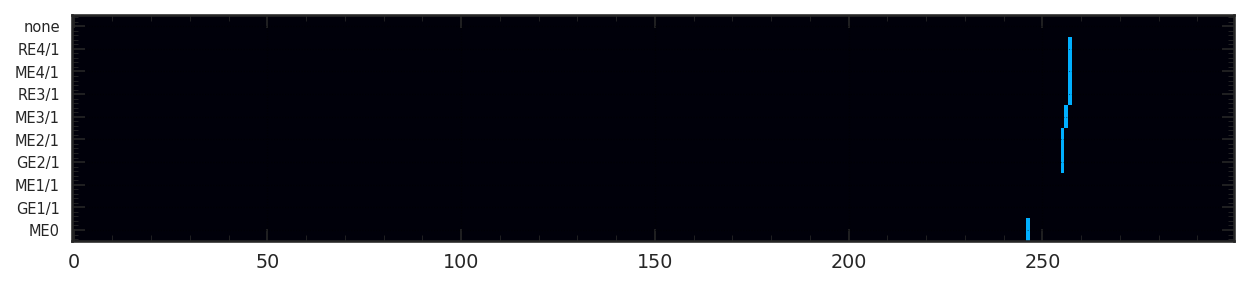

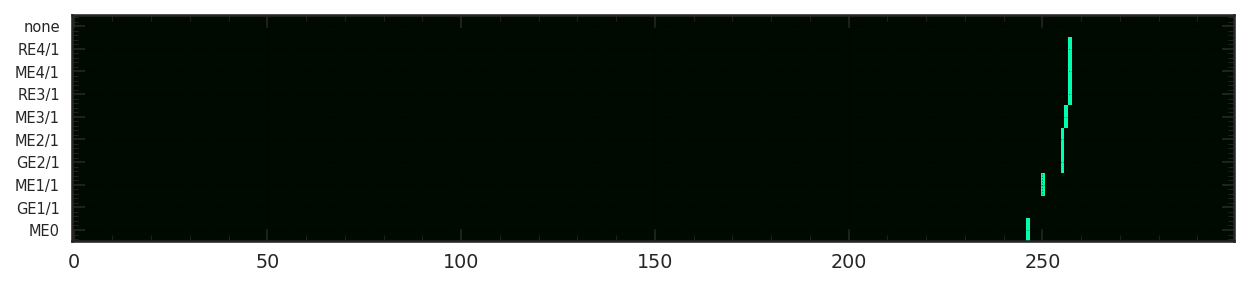

(array([0, 3, 4, 5, 6, 7, 8]), array([246, 255, 255, 256, 257, 257, 257]))
(array([0, 2, 3, 4, 5, 6, 7, 8]), array([246, 250, 255, 255, 256, 257, 257, 257]))


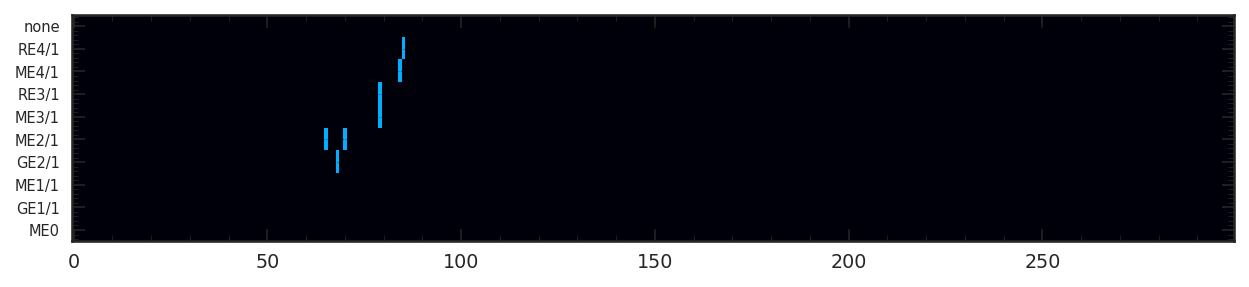

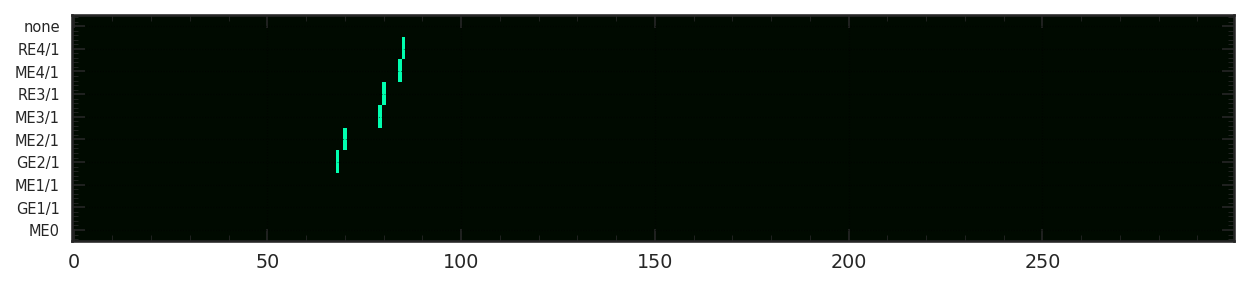

(array([3, 4, 4, 5, 6, 7, 8]), array([68, 65, 70, 79, 79, 84, 85]))
(array([3, 4, 5, 6, 7, 8]), array([68, 70, 79, 80, 84, 85]))


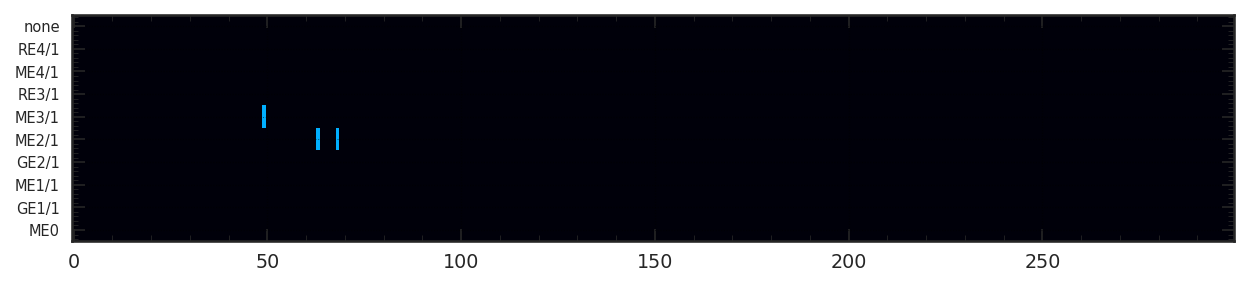

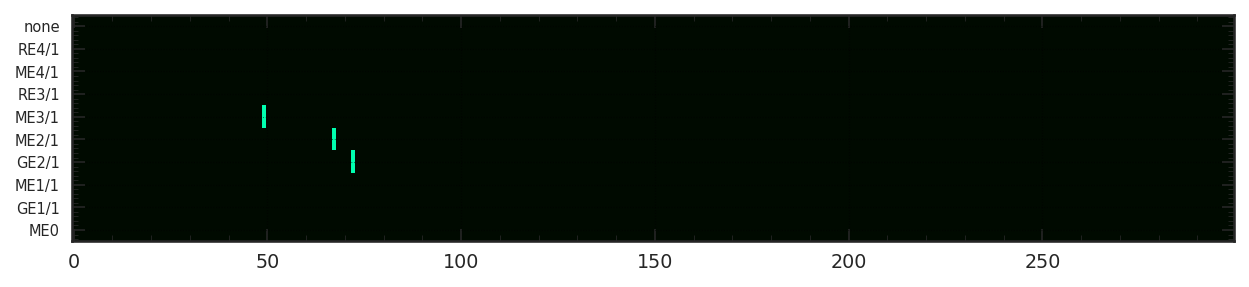

(array([4, 4, 5]), array([63, 68, 49]))
(array([3, 4, 5]), array([72, 67, 49]))


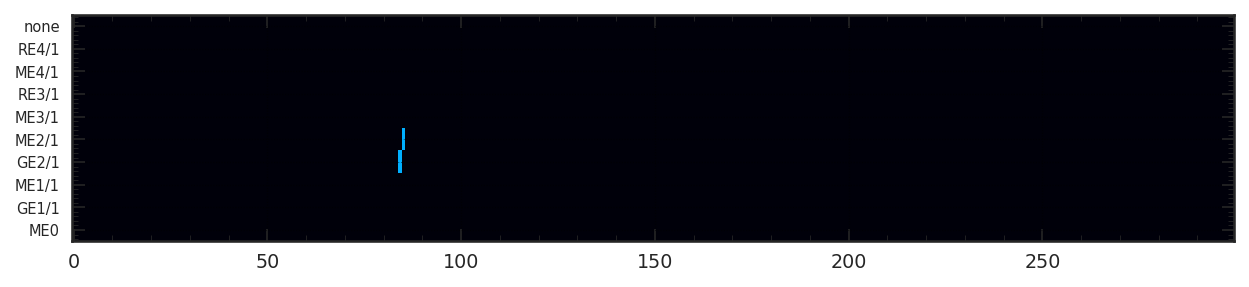

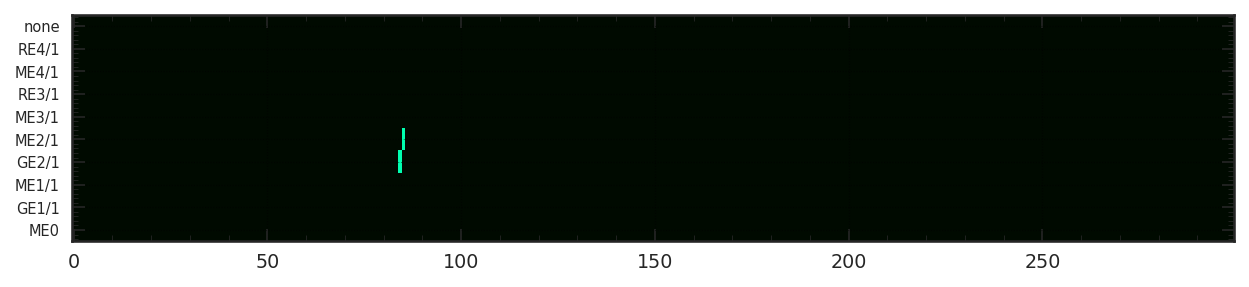

(array([3, 4]), array([84, 85]))
(array([3, 4]), array([84, 85]))


In [17]:
for ievt in range(4):
  display_image(zone, images[ievt])
  display_image(zone, images_gt[ievt], cmap=green_hot)

  print(np.nonzero(images[ievt][...,0]))
  print(np.nonzero(images_gt[ievt][...,0]))

In [18]:
# Quick check

if require_pref_row:
  pref_cols = []
  pref_cols_ch0 = []
  pref_cols_ch1 = []
  pref_cols_ch2 = []

  for img_gt in images_gt[:10000]:
    pref_col = np.argmax(img_gt[pref_row, :][...,0])
    pref_cols.append(pref_col)
    pref_cols_ch0.append(img_gt[pref_row, pref_col, 0]/1.)
    pref_cols_ch1.append(img_gt[pref_row, pref_col, 1]/15.)
    pref_cols_ch2.append(img_gt[pref_row, pref_col, 2]-128.)

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(pref_cols, range=(0,num_cols), bins=num_cols)
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(pref_cols_ch0, range=(-2,2), bins=64)
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(pref_cols_ch1, range=(-2,2), bins=64)
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(pref_cols_ch2, range=(-2,2), bins=64)
  plt.show()

In [19]:
# Quick check

if require_pref_row:
  invpt_vals = []
  dzero_vals = []

  for par in params_gt:
    (invpt, d0, eta, phi, invpt2) = par
    if np.abs(d0) <= 20.:
      invpt_vals.append(invpt2)
      invpt_vals.append(-invpt2)
    if np.abs(1.0/invpt2) >= 20.:
      dzero_vals.append(d0)
      dzero_vals.append(-d0)

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(invpt_vals, range=(-0.6,0.6), bins=100)
  ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist(dzero_vals, range=(-180,180), bins=100)
  ax.set_xlabel(r'$d_{0}$ [cm]')
  plt.show()

In [20]:
# Quick check

if require_pref_row:
  #print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))
  #print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))

  print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,22.5,42.5,57.5,77.5,99.5], overwrite_input=True)))
  print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,25,44,56,75,99.5], overwrite_input=True)))

In [21]:
# Quick check

if require_pref_row:
  invpt_vals = []
  dzero_vals = []

  for par in params_gt:
    (invpt, d0, eta, phi, invpt2) = par
    invpt_vals.append(invpt2)
    dzero_vals.append(d0)

  fig, ax = plt.subplots(1, 1, figsize=(2,2))
  _ = ax.hist2d(invpt_vals, dzero_vals, range=((-0.6,0.6),(-180,180)), bins=(100,100),
                cmap=my_cmap, vmin=1)
  ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
  ax.set_ylabel(r'$d_{0}$ [cm]')
  plt.show()

### Boxes

In [22]:
do_boxes = False

num_box_rows = num_rows

num_box_cols = 99

num_box_channels = 1

box_col_offset = 49

num_par_rows = len(invpt_bins)-1

num_par_cols = len(dzero_bins)-1

# Build boxes

def build_boxes():
  # 5 indices: (par_row, par_col, box_row, box_col, box_channel)
  boxes = np.zeros((num_par_rows, num_par_cols, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

  # Note: using images_gt
  for ievt, (img, par) in enumerate(zip(images_gt, params_gt)):
    if (ievt%10000) == 0:
      print('Building image {0}'.format(ievt))

    pref_col = np.argmax(img[pref_row, :][...,0])
    rows, cols = np.nonzero(img[...,0])

    par_row, par_col = find_par_row_col(par)
    mirror_par_row, mirror_par_col = (num_par_rows-1) - par_row, (num_par_cols-1) - par_col

    for row, col in zip(rows, cols):
      # canon image
      col = (col - pref_col) + box_col_offset
      if 0 <= col < num_box_cols:
        boxes[par_row, par_col, row, col] += 1.0
      # mirror image
      mirror_col = (num_box_cols-1) - col
      if 0 <= mirror_col < num_box_cols:
        boxes[mirror_par_row, mirror_par_col, row, mirror_col] += 1.0
  return boxes

In [23]:
%%time

if do_boxes:
  if not require_pref_row:
    raise RuntimeError('require_pref_row is set to False, but do_boxes is set to True.')

  boxes = build_boxes()
  boxes_orig = boxes.copy()

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 16 µs


In [24]:
# Apply anti-aliasing and normalization

@numba.njit
def njit_zero_pad(img, img_padded, pad_l, pad_t):
  # based on pytorch nn.ZeroPad2d
  img_padded[:] = 0
  img_padded[pad_t:pad_t+img.shape[0], pad_l:pad_l+img.shape[1]] = img
  return

@numba.njit
def njit_reflection_pad(img, img_padded, pad_l, pad_t):
  # based on pytorch nn.ReflectionPad2d
  img_padded[:] = 0

  for i in range(img_padded.shape[0]):
    if i < pad_t:
      ip_y = pad_t * 2 - i
    elif i >= img.shape[0] + pad_t:
      ip_y = (img.shape[0] + pad_t - 1) * 2 - i
    else:
      ip_y = i
    ip_y = ip_y - pad_t

    for j in range(img_padded.shape[1]):
      if j < pad_l:
        ip_x = pad_l * 2 - j
      elif j >= img.shape[1] + pad_l:
        ip_x = (img.shape[1] + pad_l - 1) * 2 - j
      else:
        ip_x = j
      ip_x = ip_x - pad_l

      # Padding
      img_padded[i, j] = img[ip_y, ip_x]
      #print((i,j), (ip_y,ip_x))
  return

@numba.njit
def njit_apply_filter(img, img_padded, filt, pad_l, pad_t):
  img[:] = 0

  for i in range(img_padded.shape[0]):
    for j in range(img_padded.shape[1]):
      if i >= pad_t and i < img.shape[0] + pad_t:
        if j >= pad_l and j < img.shape[1] + pad_l:
          ip_y = i - pad_t
          ip_x = j - pad_l

          # Receptive field of filter
          field = img_padded[i-pad_t:i+pad_t+1, j-pad_l:j+pad_l+1]

          # Matrix multiplication
          if (field > 0).any():
            #img[ip_y, ip_x] = np.sum(filt * field)
            for k in range(filt.shape[0]):
              for kk in range(filt.shape[1]):
                for kkk in range(filt.shape[2]):
                  img[ip_y, ip_x] += (filt[k, kk, kkk] * field[k, kk, kkk])
  return

# Reference:
#   https://github.com/adobe/antialiased-cnns
#   https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/ReflectionPad.cpp

class Antialiaser(object):
  def __init__(self):
    self.filt_size = 3
    self.pad_l = 1
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    old_shape = box_shape
    new_shape = (old_shape[0] + self.pad_t * 2, old_shape[1] + self.pad_l * 2, old_shape[2])
    self.img_padded = np.zeros(new_shape, dtype=np.float32)

    #self.filt = np.array([1., 2., 1.])  # 1D
    self.filt = np.array([1., 4., 1.])  # 1D
    self.filt = self.filt / np.sum(self.filt)
    self.filt = self.filt.reshape(1, self.filt_size, 1)

  def __call__(self, img):
    # Add padding
    njit_reflection_pad(img, self.img_padded, self.pad_l, self.pad_t)
    # Apply filter
    njit_apply_filter(img, self.img_padded, self.filt, self.pad_l, self.pad_t)
    return img

# As function
antialias_image = Antialiaser()

class Normalizer(object):
  def __call__(self, img):
    norm = np.sqrt(np.square(img).sum(axis=-2, keepdims=True))
    norm[norm == 0] = 1.0
    img /= norm
    img[img < 1e-2] = 0.0
    return img

# As function
normalize_image = Normalizer()


In [25]:
# Display boxes

def display_boxes(zone, boxes_orig, boxes, cmap=None, figsize=(7.5,7.5)):
  fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=figsize, tight_layout=True, sharex=True, sharey=True)
  for i in range(num_par_rows):
    for j in range(num_par_cols):
      ax = axs[(num_par_rows-1)-i, j]  # axs[0,0] is top left
      boxes[i, j] = boxes_orig[i, j]
      #img_orig = boxes_orig[i, j]
      img = boxes[i, j]
      antialias_image(img)
      normalize_image(img)
      #print(i, j, img_orig.sum(), img.sum())
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
      for x in [-40, -20, 0, +20, 40]:  # custom grid lines
        ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

def display_specific_boxes(zone, boxes_orig, boxes, cmap=None, figsize=(6,6/2)):
  # (2,2) vs (2,0)
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  for i in range(2):
    if i == 0:
      img = boxes[2, 2]
    elif i == 1:
      img = boxes[2, 0]
    ax = axs[i]
    ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto', cmap=cmap)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    for x in [-40, -20, 0, +20, 40]:  # custom grid lines
      ax.plot([box_col_offset+x,box_col_offset+x], [-0.5,num_box_rows-0.5], color='w', alpha=0.4, linewidth=0.5, linestyle=':')
  plt.show()

In [26]:
if do_boxes:
  with np.printoptions(precision=3) as opts:
    display_boxes(zone, boxes_orig, boxes)
    display_specific_boxes(zone, boxes_orig, boxes)
    print(boxes_orig[2, 2, :, box_col_offset-5:box_col_offset+6, 0])
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

In [27]:
# Find the similarities among the boxes

def kullback_leibler_divergence(y_true, y_pred, eps = 1e-7):
  # See https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
  y_true = np.clip(y_true, eps, 1)
  y_pred = np.clip(y_pred, eps, 1)
  return np.sum(y_true * np.log(y_true / y_pred))

find_kl_loss = kullback_leibler_divergence

if do_boxes:
  losses = np.zeros((num_par_rows, num_par_cols, num_par_rows, num_par_cols), dtype=np.float32)

  box1_saved = None
  box2_saved = None

  for index1 in np.ndindex(num_par_rows, num_par_cols):
    for index2 in np.ndindex(num_par_rows, num_par_cols):
      box1 = boxes_orig[index1].copy()
      box2 = boxes_orig[index2].copy()
      box1 = box1[..., 0]
      box2 = box2[..., 0]
      box1_sum = box1.sum(axis=-1, keepdims=True)
      box2_sum = box2.sum(axis=-1, keepdims=True)
      box1 = np.where(box1_sum == 0, 0, box1/box1_sum)
      box2 = np.where(box2_sum == 0, 0, box2/box2_sum)
      loss = find_kl_loss(box1, box2)
      loss /= num_par_rows
      print(index1, index2, loss)
      losses[index1][index2] = loss
      if index1 == (0,0) and index2 == (2,2):
        box1_saved = box1
        box2_saved = box2

In [28]:
if do_boxes:
  fig, axs = plt.subplots(num_rows//5, 5, figsize=(2*5/2,2), tight_layout=True)
  for i in range(num_rows):
    ax = axs[i//5, i%5]
    ax.plot(np.arange(box1_saved[i].shape[0]), box1_saved[i], color='C1')
    ax.plot([box_col_offset, box_col_offset], [5e-3, 1e0], '--', color='#cccccc')
    ax.set_ylim(5e-3, 1e0)
    ax.set_yscale('log')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
  plt.show()

  fig, axs = plt.subplots(2, num_rows//2, figsize=(2*5/2,2), tight_layout=True)
  for i in range(num_rows):
    ax = axs[i//5, i%5]
    ax.plot(np.arange(box2_saved[i].shape[0]), box2_saved[i], color='C2')
    ax.plot([box_col_offset, box_col_offset], [5e-3, 1e0], '--', color='#cccccc')
    ax.set_ylim(5e-3, 1e0)
    ax.set_yscale('log')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
  plt.show()

  fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=(7.5,7.5), tight_layout=True)
  for i in range(num_par_rows * num_par_cols):
    ax = axs[(num_par_rows-1) - i//5, i%5]   # axs[0,0] is top left
    xedges = np.arange(num_par_cols+1)
    yedges = np.arange(num_par_rows+1)
    h = losses[i//5, i%5]
    if (i//5) == 2 and (i%5) == 2:
      print(i, i//5, i%5, h)
    _ = hist2d_on_binned_array(h.T, xedges, yedges, ax=ax, colorbar=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
  plt.show()

[INFO    ] Loading from boxes_zone0.1.npz
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


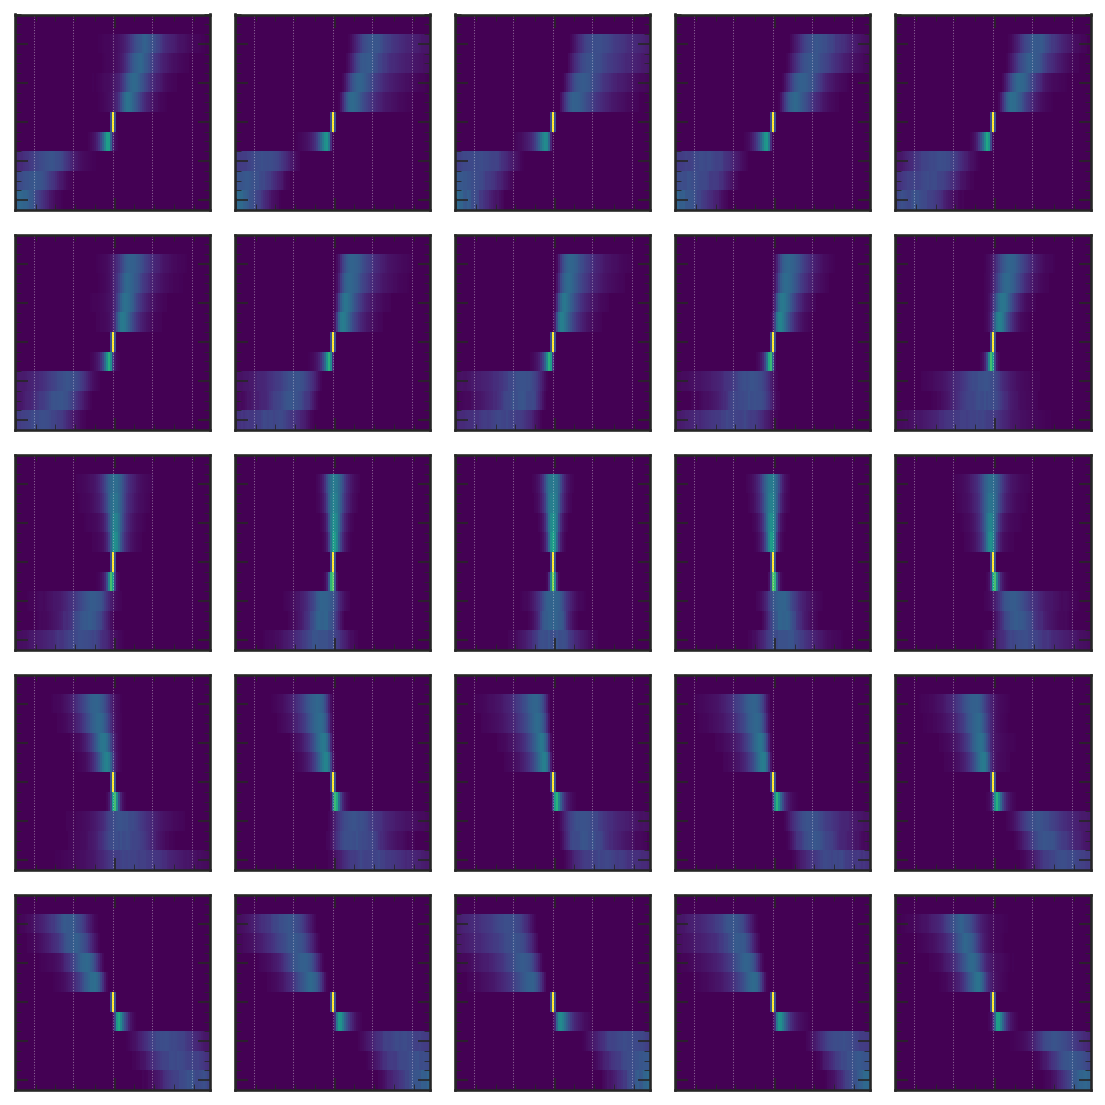

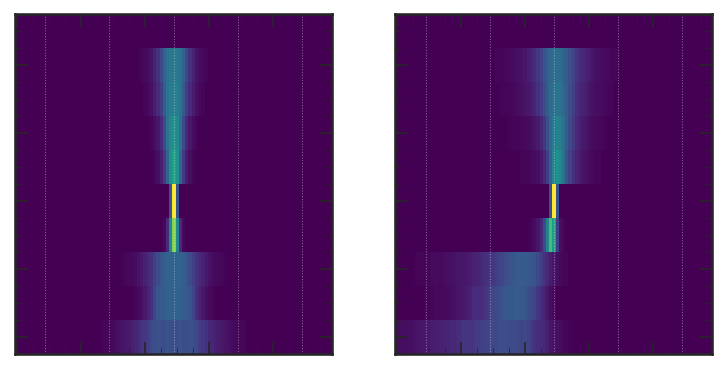

[[  363.   349.   333.   397.   344.   350.   344.   397.   333.   349.
    363.]
 [  251.   278.   267.   297.   312.   278.   312.   297.   267.   278.
    251.]
 [  536.   628.   709.   725.   728.   748.   728.   725.   709.   628.
    536.]
 [    0.    22.   119.   672.  3612.  8686.  3612.   672.   119.    22.
      0.]
 [    0.     0.     0.     0.     0. 18326.     0.     0.     0.     0.
      0.]
 [  216.   467.   945.  1918.  3216.  3582.  3216.  1918.   945.   467.
    216.]
 [  318.   625.  1148.  2047.  2564.  2706.  2564.  2047.  1148.   625.
    318.]
 [  529.   780.  1288.  1711.  1912.  1870.  1912.  1711.  1288.   780.
    529.]
 [  587.   884.  1331.  1575.  1673.  1632.  1673.  1575.  1331.   884.
    587.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.]]
[[0.231 0.225 0.223 0.244 0.228 0.225 0.228 0.244 0.223 0.225 0.231]
 [0.247 0.271 0.273 0.294 0.303 0.289 0.303 0.294 0.273 0.271 0.247]
 [0.219 0.257 0.287 0.297 0.3   0.305 0.3

In [29]:
if do_boxes:
  # Write
  outfile = 'boxes_zone%i.npz' % zone
  save_np_arrays(outfile, dict(boxes=boxes, boxes_orig=boxes_orig))
  logger.info('Wrote to {0}'.format(outfile))
else:
  # Read
  infile = 'boxes_zone%i.1.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    boxes = f['boxes']
    boxes_orig = f['boxes_orig']

  # Display boxes
  with np.printoptions(precision=3) as opts:
    display_boxes(zone, boxes_orig, boxes)
    display_specific_boxes(zone, boxes_orig, boxes)
    print(boxes_orig[2, 2, :, box_col_offset-5:box_col_offset+6, 0])
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

### Annotations (trial)

In [30]:
do_annotations_trial = True

num_annot_rows = num_par_rows * num_par_cols

num_annot_cols = num_cols

num_annot_labels = num_annot_rows

num_annot_extra_labels = 1  # (pref_cols,)

@numba.njit
def njit_annotate_image(img, img_annot, boxes, pad_l, pad_t):
  num_cols = img.shape[1]
  num_box_cols = boxes[0].shape[1]
  img_annot[:] = 0

  for i in range(0, 1):
    for j in range(num_cols):
      start = max(0, j-pad_l)
      end = min(num_cols, j+pad_l+1)
      b_start = max(0, num_box_cols - end)
      b_end = min(num_box_cols, num_cols - start)
      ## assert
      #assert(len(range(start, end)) == len(range(b_start, b_end)))

      # Receptive field of filter
      field = img[:, start:end, 0]

      # Matrix multiplication
      if (field > 0).any():
        for k in range(boxes.shape[0]):
          box = boxes[k, :, b_start:b_end, 0]
          for kk in range(box.shape[0]):
            for kkk in range(box.shape[1]):
              img_annot[k, j] += (box[kk, kkk] * field[kk, kkk])
  return

# Set the number of threads
numba.config.NUMBA_NUM_THREADS = 32

@numba.njit(parallel=True)
def njit_annotate_image_parallel(images_gt, annotations, boxes, pad_l, pad_t):
  for ievt in numba.prange(len(annotations)):
    img = images_gt[ievt]
    img = img[..., 0:1]  # only use img ch0
    img_annot = annotations[ievt]
    njit_annotate_image(img, img_annot, boxes, pad_l, pad_t)
  return

class Annotater(object):
  def __init__(self):
    self.pad_l = box_col_offset
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    self.boxes = boxes.copy()
    self.boxes = self.boxes.reshape(-1, box_shape[0], box_shape[1], box_shape[2])

  def __call__(self, images_gt, annotations):
    njit_annotate_image_parallel(images_gt, annotations, self.boxes, self.pad_l, self.pad_t)
    return

# As function
annotate_images = Annotater()

def build_annotations_trial():
  # Reserve arrays
  batch_size = 100000
  annotations_batch = np.zeros((batch_size, num_annot_rows, num_annot_cols), dtype=np.float32)
  # Do work
  print('Building images')
  images_gt_batch = images_gt[:batch_size]
  annotate_images(images_gt_batch, annotations_batch)
  return annotations_batch

In [31]:
%%time

if do_annotations_trial:
  annotations = build_annotations_trial()

Building images
CPU times: user 12min 45s, sys: 4.02 s, total: 12min 49s
Wall time: 27.8 s


In [32]:
# Display annotation

single_val = lambda t: t[0]

def display_annotation(zone, par, annot, cmap=None, figsize=(3,4)):
  par_row, par_col = find_par_row_col(par)
  imaxx = np.argmax(np.max(annot, axis=0))

  fig, axs = plt.subplots(2, 1, figsize=figsize, tight_layout=True, gridspec_kw=dict(height_ratios=(1,3)))
  ax = axs[0]
  ax.imshow(np.atleast_2d(np.max(annot, axis=0)), origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.set_xticks([0, 100, 200, 300])
  ax.set_yticks([])

  ax = axs[1]
  ax.imshow(annot[:, imaxx].reshape(5,5), origin='lower', interpolation='none', aspect='auto', cmap=cmap)
  ax.text(par_col, par_row, r'$\star$', ha='center', va='center', fontsize=20, color='red')
  plt.show()

In [33]:
if do_annotations_trial:
  for ievt in range(15):
    #display_image(zone, images_gt[ievt], cmap=green_hot)

    with np.printoptions(linewidth=50, precision=6) as opts:
      print(ievt)
      #print(single_val(np.nonzero(images[ievt][pref_row,:,0])))
      print(single_val(np.nonzero(images_gt[ievt][pref_row,:,0])))
      print(params_gt[ievt], find_par_row_col(params_gt[ievt]))

      imax = np.argmax(annotations[ievt])
      imaxx = np.argmax(np.max(annotations[ievt], axis=0))
      print(imax, imaxx, (imax%num_cols, imax//num_cols), ((imax//num_cols)//num_par_cols, (imax//num_cols)%num_par_cols))
      print(np.max(annotations[ievt]), annotations[ievt][imax//num_cols, imax%num_cols], np.max(annotations[ievt][:, imaxx]))
      print(annotations[ievt,:,imaxx],)

0
[255]
[-0.072867  6.344836  1.981351  2.143856
 -0.072867] (2, 1)
3555 255 (255, 11) (2, 1)
3.868678 3.868678 3.868678
[0.977566 0.958457 0.954687 0.959516 1.162545
 1.835359 1.255906 1.10446  1.064918 1.288262
 3.454487 3.868678 3.627217 2.879729 2.564363
 1.684307 1.266687 1.494576 2.238592 2.778971
 1.282648 0.959516 0.954687 0.958457 0.977566]
1
[70]
[ -0.366596 141.08421    2.646965  -1.079281
  -0.366596] (4, 0)
6070 70 (70, 20) (4, 0)
2.73136 2.73136 2.73136
[0.942809 0.942809 0.942809 0.942809 0.968516
 0.9984   0.942809 0.942809 0.942809 0.978777
 1.52695  1.223874 1.060396 0.981805 1.053926
 2.460706 2.52511  2.447109 2.268966 2.090986
 2.73136  2.341732 2.066194 2.175512 2.408945]
2
[67]
[  -0.418642 -139.04509     2.245461    1.154157
   -0.418642] (0, 0)
667 67 (67, 2) (0, 2)
1.5515323 1.5515323 1.5515323
[1.405069 1.525697 1.551532 1.500419 1.320863
 0.992078 1.061155 1.167141 1.200019 1.179323
 0.942809 0.942809 0.942809 0.953105 0.998414
 0.942809 0.942809 0.942809 0.

0


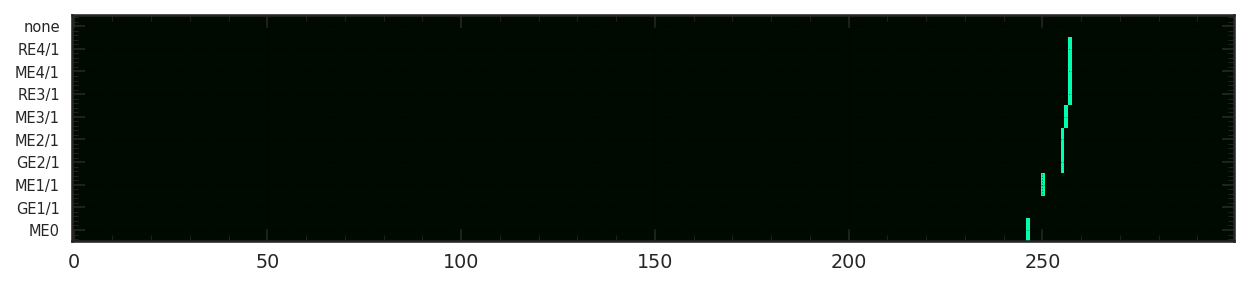

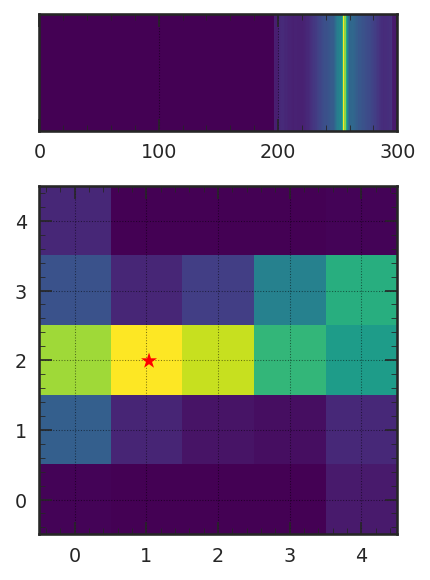

1


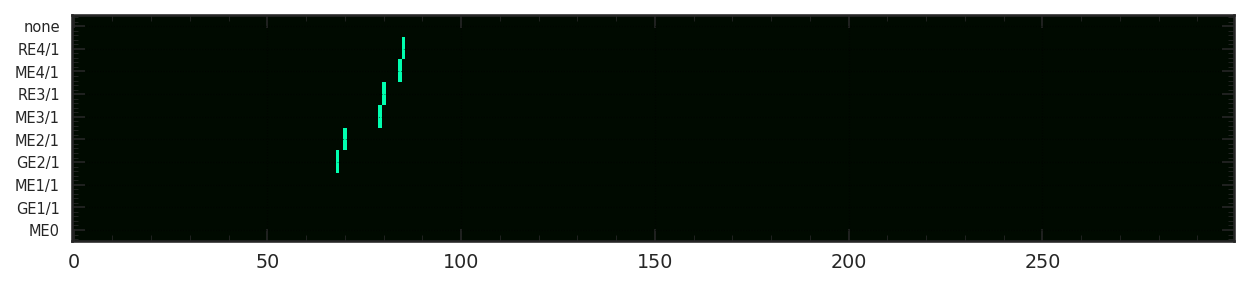

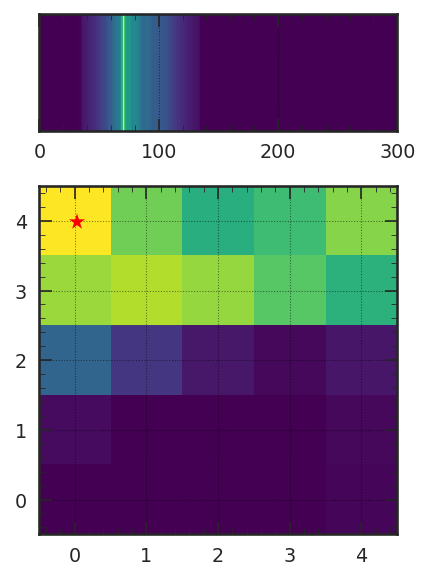

2


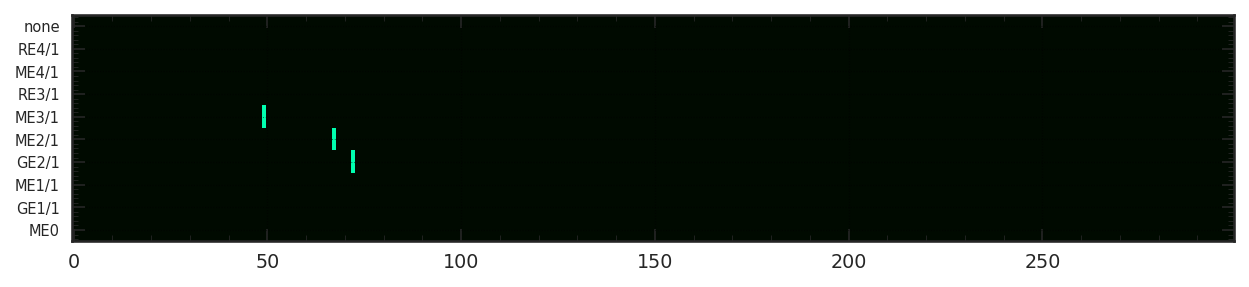

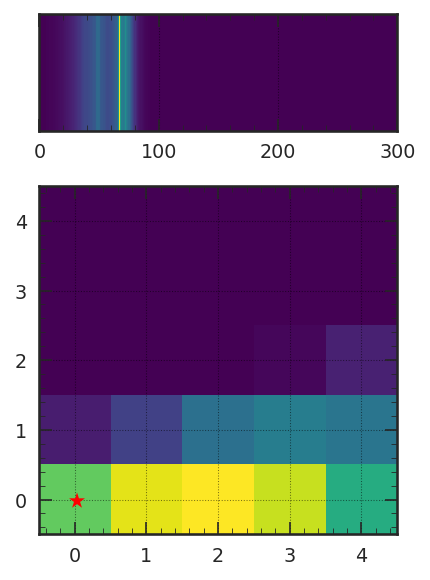

3


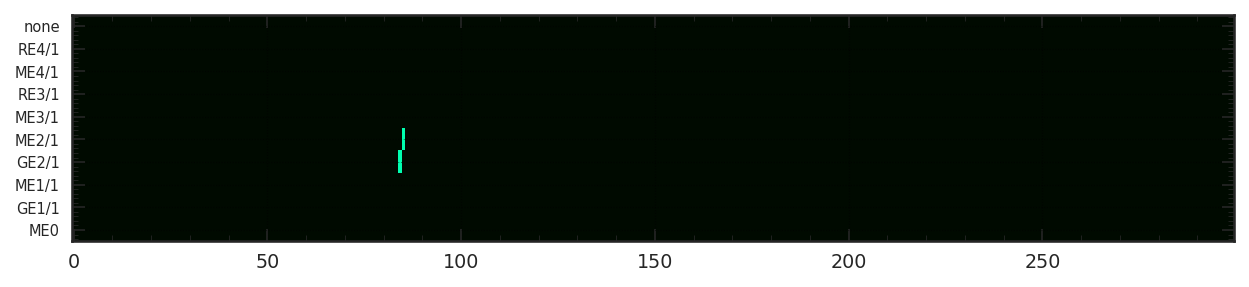

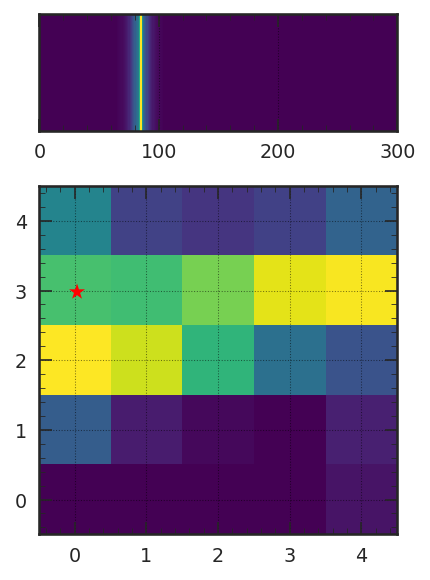

4


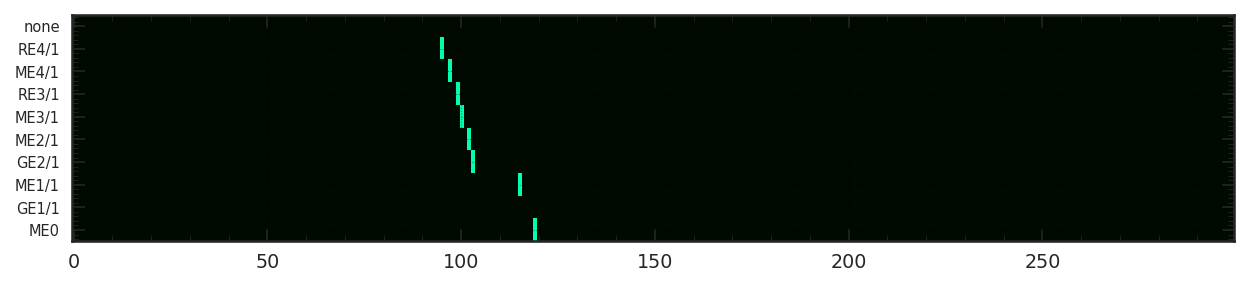

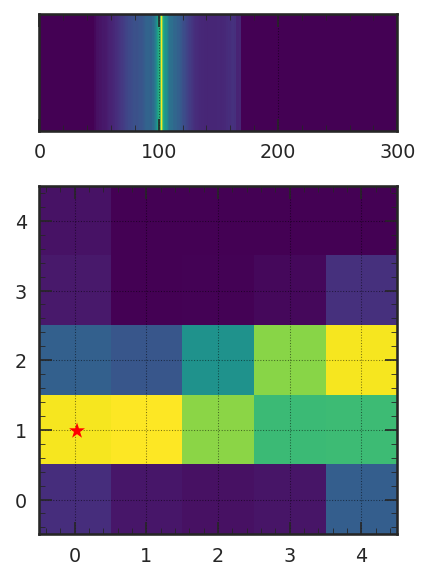

5


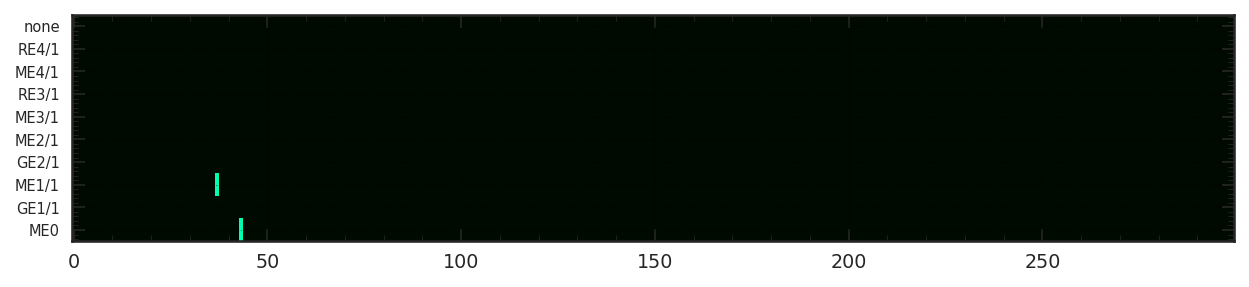

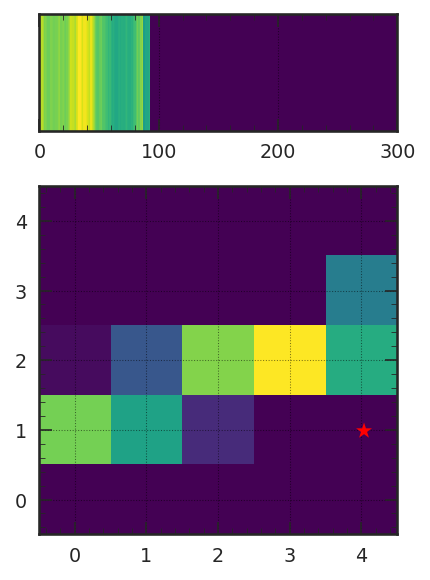

8


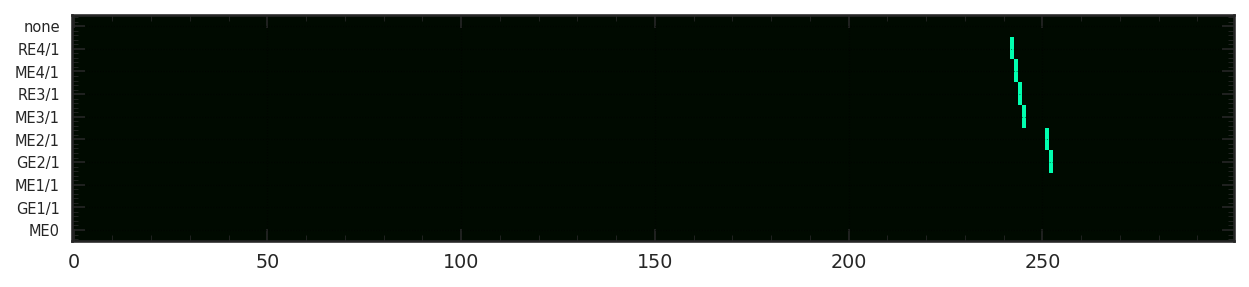

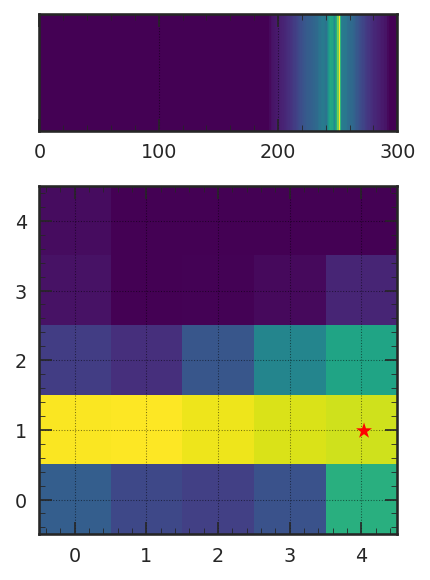

9


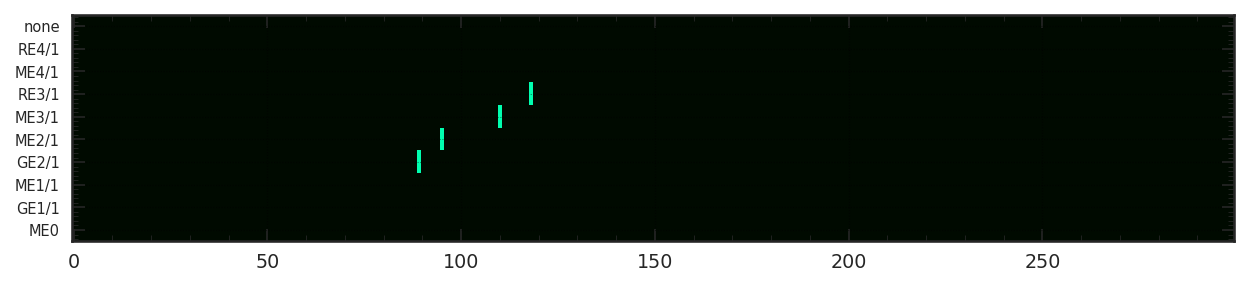

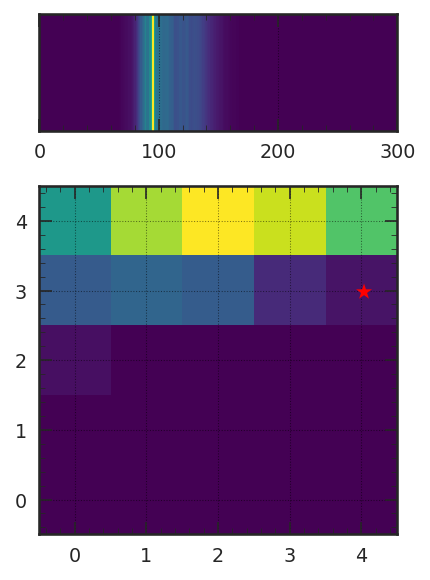

10


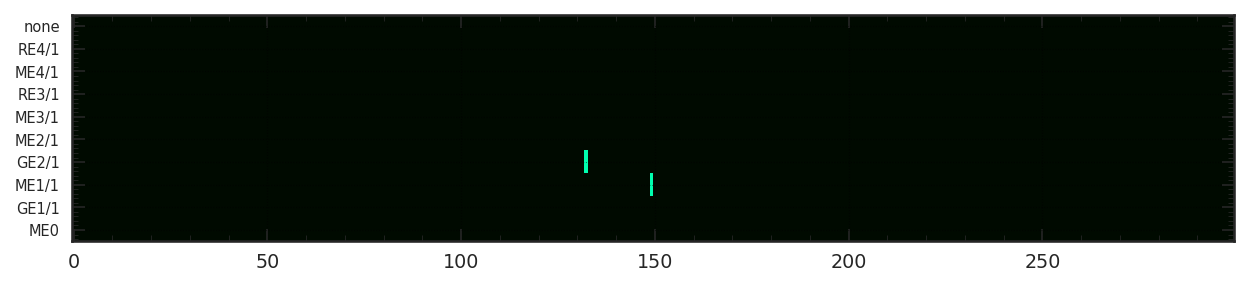

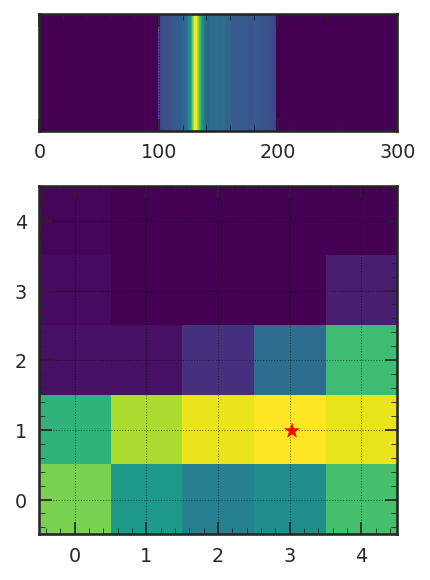

11


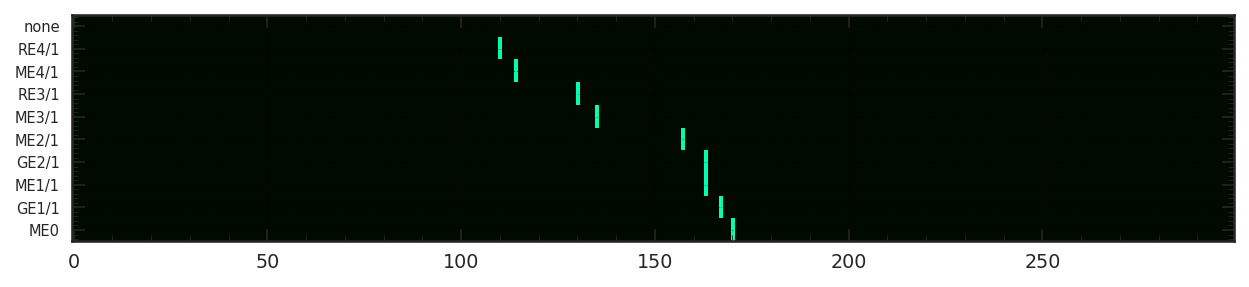

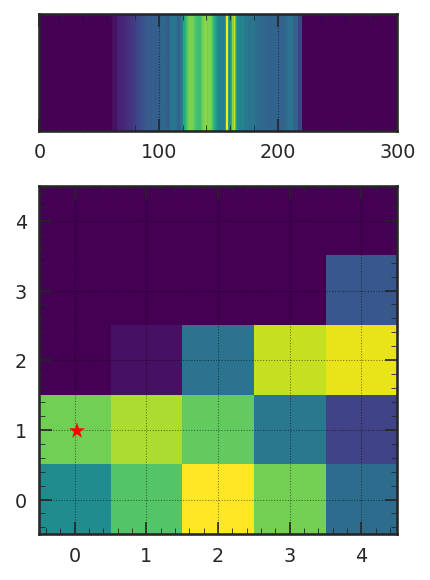

14


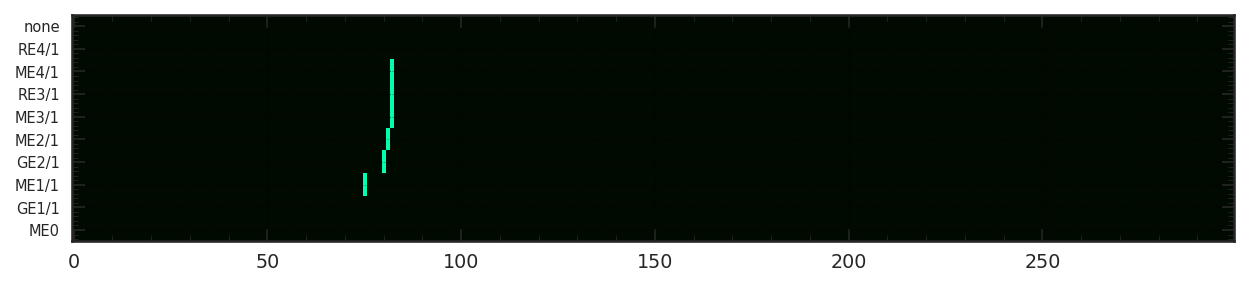

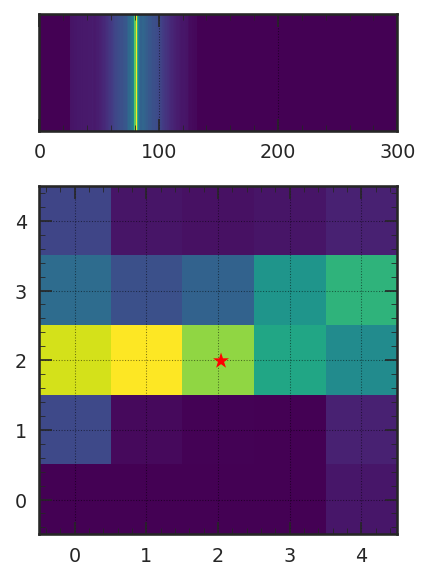

In [34]:
if do_annotations_trial:
  for ievt in [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 14]:
    print(ievt)
    display_image(zone, images_gt[ievt], cmap=green_hot)
    display_annotation(zone, params_gt[ievt], annotations[ievt])

In [35]:
# Decide activations

def find_top_k(arr, k=5):
  # Based on https://stackoverflow.com/q/6910641
  indices = np.argpartition(arr, -k)[-k:]
  return indices[np.argsort(arr[indices])][::-1]

if do_annotations_trial:
  activations_1 = []
  activations_2 = []

  for ievt, (img, par, annot) in enumerate(zip(images_gt, params_gt, annotations)):
    par_row, par_col = find_par_row_col(par)
    imaxx = np.argmax(np.max(annot, axis=0))
    annot_at_imaxx = annot[:, imaxx]
    annot_at_imaxx_topk = annot_at_imaxx[find_top_k(annot_at_imaxx)]
    #print(annot_at_imaxx, annot_at_imaxx_topk)
    if img[pref_row, :, 0].sum() > 0:  # has valid hit in ME2
      for x in annot_at_imaxx_topk:
        activations_1.append(x)
    else:
      for x in annot_at_imaxx_topk:
        activations_2.append(x)

  activations_1 = np.asarray(activations_1)
  activations_2 = np.asarray(activations_2)

(421090,) 0.7942876 4.350672
[0.96078157 1.45277548 1.88973263 2.45815325 2.83905089 3.15948749
 3.93310666]


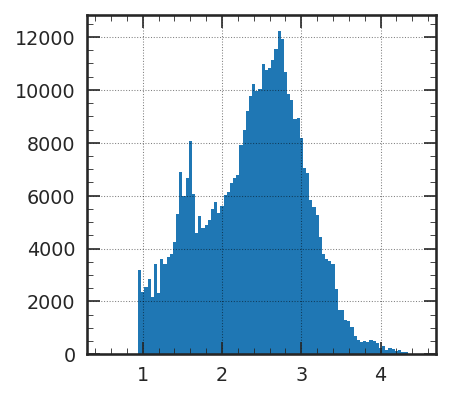

(78910,) 0.20972084 2.944448
[0.30226192 0.43084756 0.54833561 0.80066633 1.08134055 1.389889
 2.01314767]


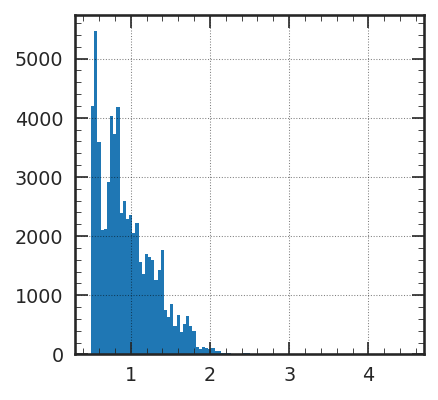

In [36]:
if do_annotations_trial:
  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  print(activations_1.shape, activations_1.min(), activations_1.max())
  print(np.percentile(activations_1, q=[0.5,10,25,50,75,90,99.5], overwrite_input=True))
  _ = ax.hist(activations_1, range=(0.5,4.5), bins=100)
  plt.show()

  if len(activations_2):
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    print(activations_2.shape, activations_2.min(), activations_2.max())
    print(np.percentile(activations_2, q=[0.5,10,25,50,75,90,99.5], overwrite_input=True))
    _ = ax.hist(activations_2, range=(0.5,4.5), bins=100)
    plt.show()

### Annotations

In [37]:
do_annotations = True

import h5py

f_hdf5 = None  # file handle

annotations_filename = ('annotations_zone%i.h5' % zone)

#annotations_size = len(images)
annotations_size = 500000  # needs to be a multiple of 'batch_size'

batch_size = 100000

In [38]:
@numba.njit(parallel=True)
def njit_extract_image_parallel(images, images_extract, pref_cols, pad_l, pad_t):
  for ievt in numba.prange(len(images)):
    img = images[ievt]
    img = img[..., 0:1]  # only use img ch0
    img_extract = images_extract[ievt]
    img_extract[:] = 0
    pref_col = pref_cols[ievt]
    if pref_col < pad_l:
      end = pref_col + pad_l + 1
      img_extract[:, -end:] = img[:, :end]
    elif pref_col >= img.shape[1] + pad_l - img_extract.shape[1]:
      start = pref_col - pad_l
      img_extract[:, :(img.shape[1] - start)] = img[:, start:]
    else:
      start = pref_col - pad_l
      end = pref_col + pad_l + 1
      img_extract[:, :] = img[:, start:end]
  return

@numba.njit(parallel=True)
def njit_extract_label_parallel(labels, labels_extract, pref_cols, pad_l, pad_t):
  for ievt in numba.prange(len(labels)):
    lab = labels[ievt]
    lab_extract = labels_extract[ievt]
    lab_extract[:] = 0
    lab_extract[lab] = 1
  return

class Extractor(object):
  def __init__(self):
    self.pad_l = box_col_offset
    self.pad_t = 0

  def __call__(self, images, params_gt, images_extract, labels_extract, pref_cols):
    # Extract images
    njit_extract_image_parallel(images, images_extract, pref_cols, self.pad_l, self.pad_t)
    # Extract labels
    par_row, par_col = find_par_row_col(params_gt)
    labels = (par_row * num_par_cols) + par_col
    njit_extract_label_parallel(labels, labels_extract, pref_cols, self.pad_l, self.pad_t)
    return

# As function
extract_images = Extractor()


def build_annotations():
  # Create file
  global f_hdf5
  f_hdf5 = h5py.File(annotations_filename, 'w')
  images_x_hdf5 = f_hdf5.create_dataset('images_x',
                                        (annotations_size, num_box_rows, num_box_cols, num_box_channels), dtype=np.uint8)
  images_y_hdf5 = f_hdf5.create_dataset('images_y',
                                        (annotations_size, num_annot_labels), dtype=np.uint8)
  images_c_hdf5 = f_hdf5.create_dataset('images_c',
                                        (annotations_size, num_annot_extra_labels), dtype=np.int32)

  images_hdf5 = f_hdf5.create_dataset('images', images.shape, dtype=images.dtype)
  images_gt_hdf5 = f_hdf5.create_dataset('images_gt', images_gt.shape, dtype=images_gt.dtype)
  params_gt_hdf5 = f_hdf5.create_dataset('params_gt', params_gt.shape, dtype=params_gt.dtype)

  # Reserve arrays
  annotations_batch = np.zeros((batch_size, num_annot_rows, num_annot_cols), dtype=np.float32)
  images_x_batch = images_x_hdf5[:batch_size][:]
  images_y_batch = images_y_hdf5[:batch_size][:]
  images_c_batch = images_c_hdf5[:batch_size][:]

  # Do work
  print('Building images')
  batches = make_batches(size=annotations_size, batch_size=batch_size)
  for batch_index, (batch_start, batch_end) in enumerate(batches):
    print('batch {0} {1}'.format(batch_index, (batch_start, batch_end)))
    images_batch = images[batch_start:batch_end]
    images_gt_batch = images_gt[batch_start:batch_end]
    params_gt_batch = params_gt[batch_start:batch_end]
    annotate_images(images_gt_batch, annotations_batch)

    # Find pref_cols
    np.argmax(annotations_batch.sum(axis=-2), axis=-1, out=images_c_batch[:, 0])

    # Extract images
    extract_images(images_batch, params_gt_batch, images_x_batch, images_y_batch, images_c_batch[:, 0])

    ## Write to file
    images_x_hdf5[batch_start:batch_end] = images_x_batch
    images_y_hdf5[batch_start:batch_end] = images_y_batch
    images_c_hdf5[batch_start:batch_end] = images_c_batch

    images_hdf5[batch_start:batch_end] = images_batch
    images_gt_hdf5[batch_start:batch_end] = images_gt_batch
    params_gt_hdf5[batch_start:batch_end] = params_gt_batch

  # Close file
  f_hdf5.close()
  return

In [39]:
%%time

if do_annotations:
  _ = build_annotations()

Building images
batch 0 (0, 100000)
batch 1 (100000, 200000)
batch 2 (200000, 300000)
batch 3 (300000, 400000)
batch 4 (400000, 500000)
CPU times: user 1h 5min 23s, sys: 34 s, total: 1h 5min 57s
Wall time: 2min 40s


In [40]:
#FIXME: enlarge window to 30 deg
#FIXME: reduce num of labels from 25 to 11
#FIXME: add fake images
#FIXME: include prompt muons
#FIXME: mix with PU images

0
[11]
[255]


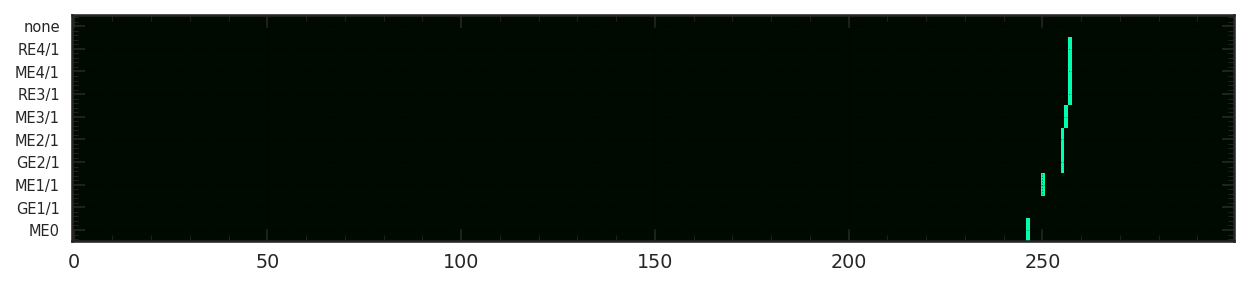

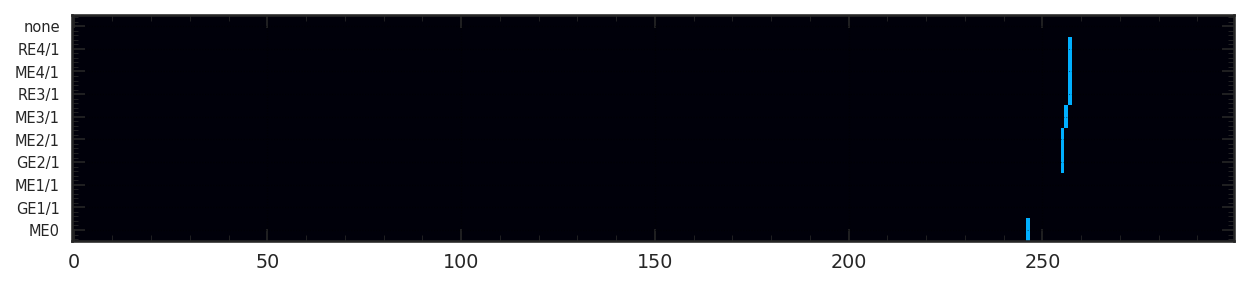

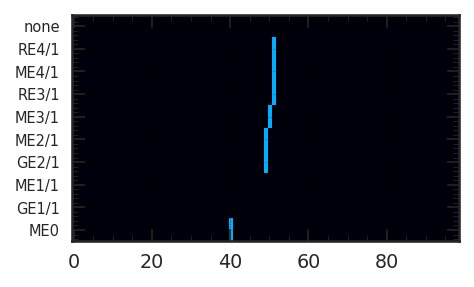

1
[20]
[70]


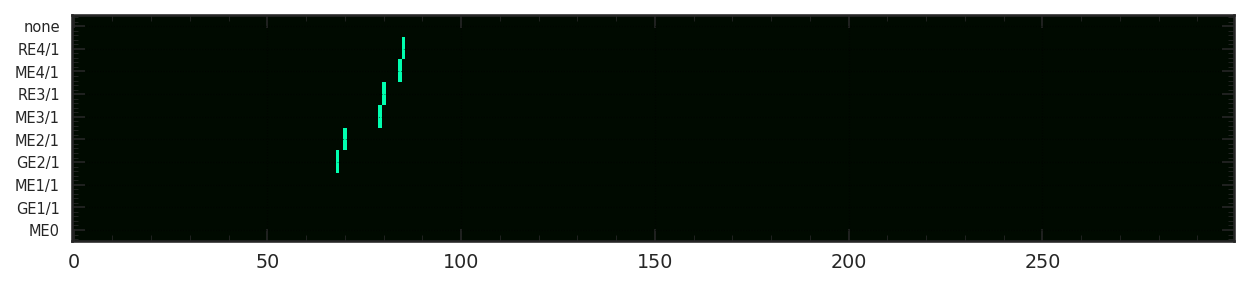

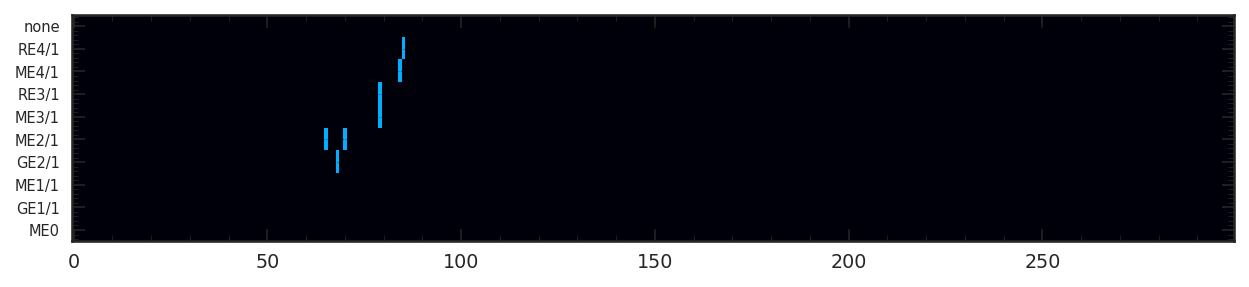

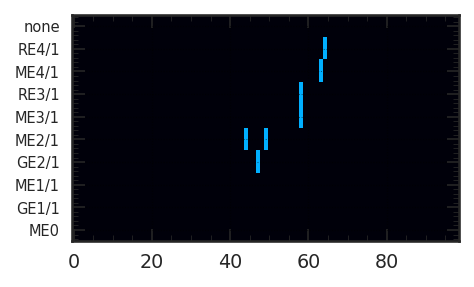

2
[0]
[67]


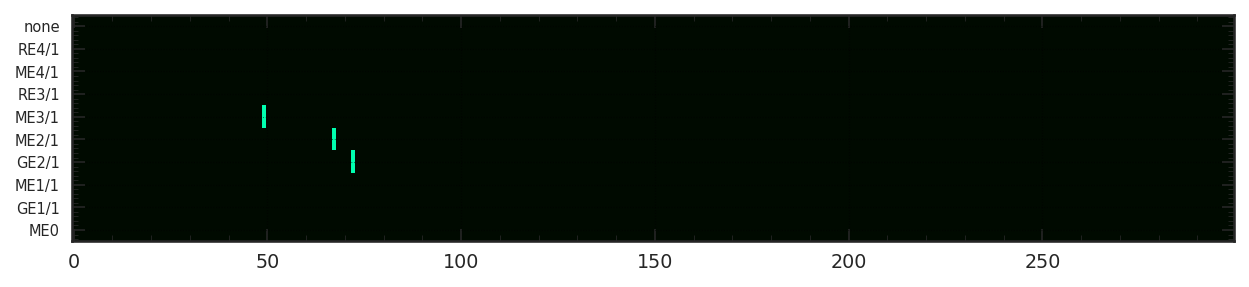

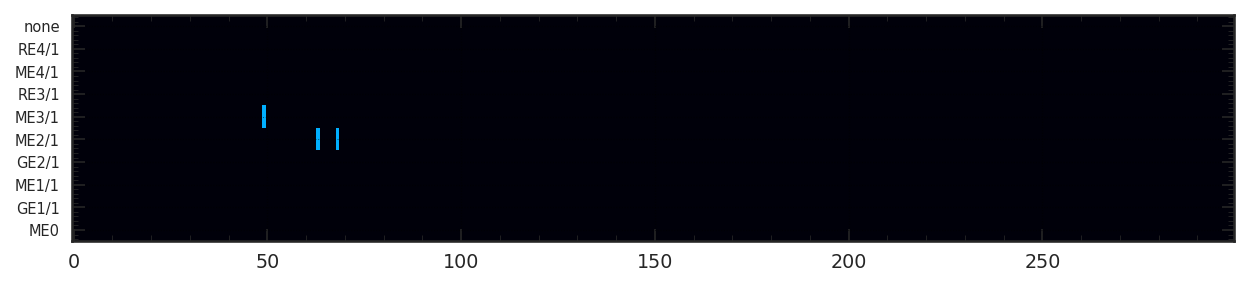

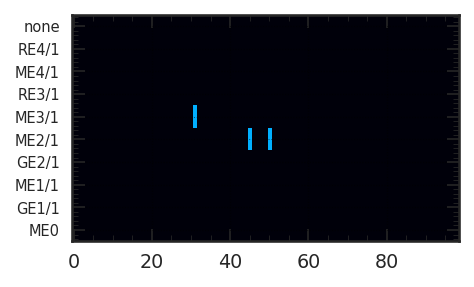

3
[15]
[85]


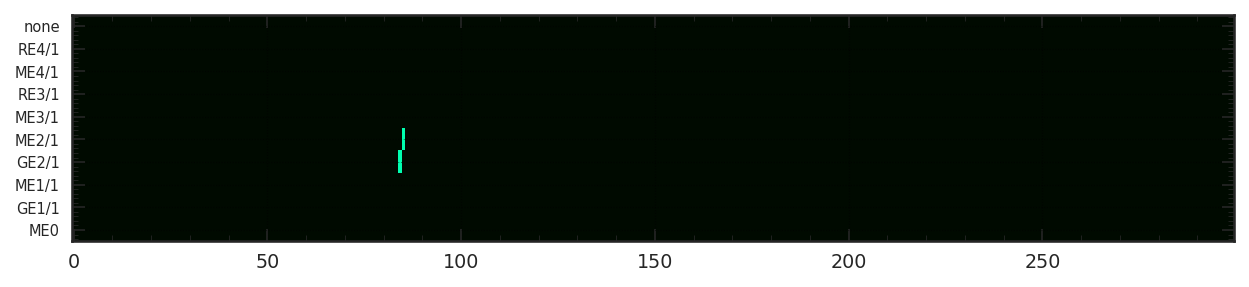

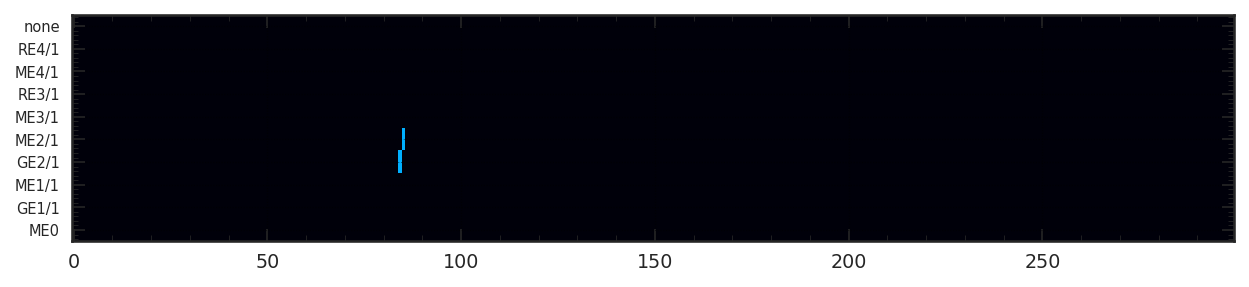

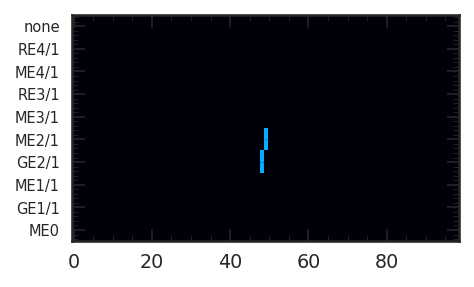

4
[5]
[102]


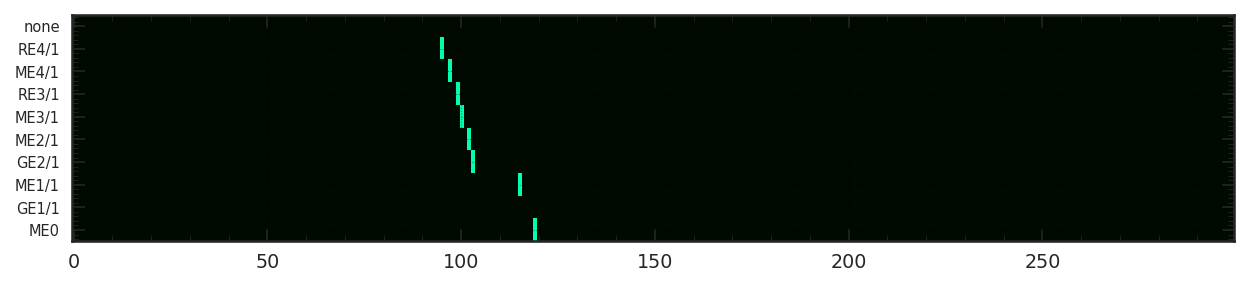

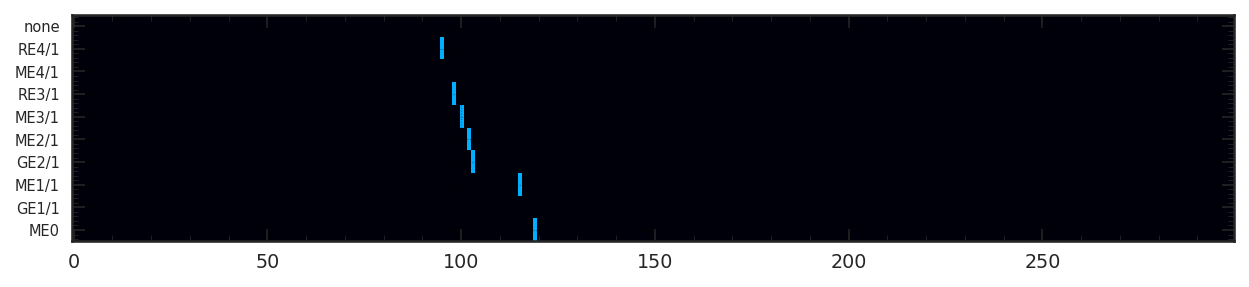

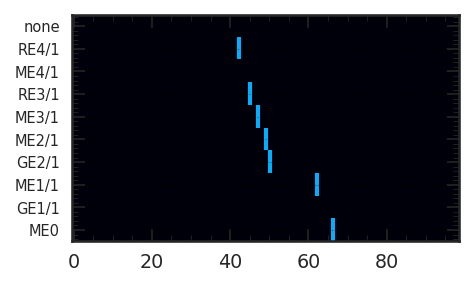

5
[9]
[3]


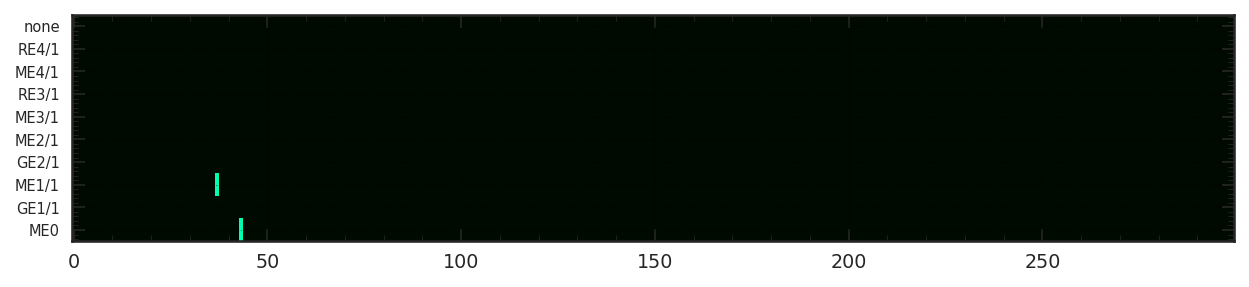

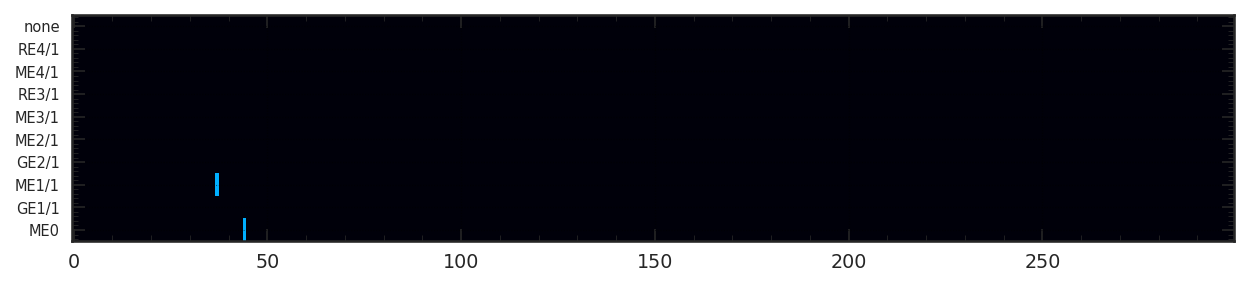

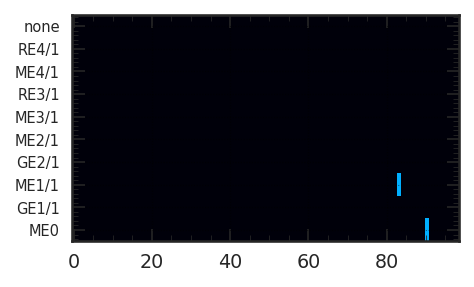

6
[19]
[196]


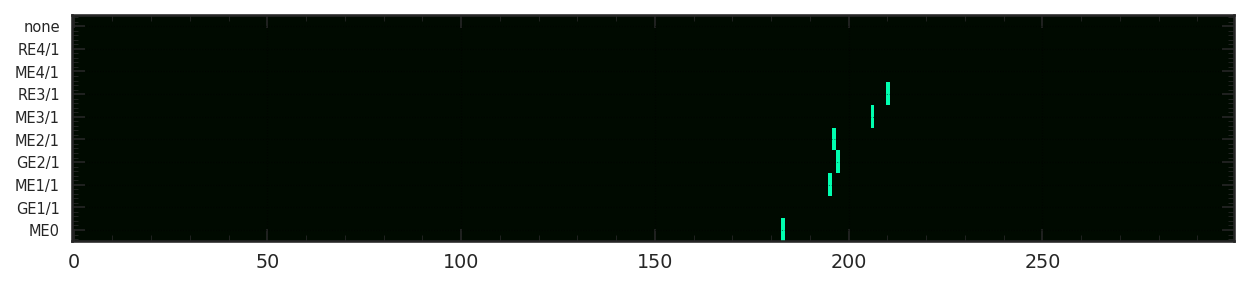

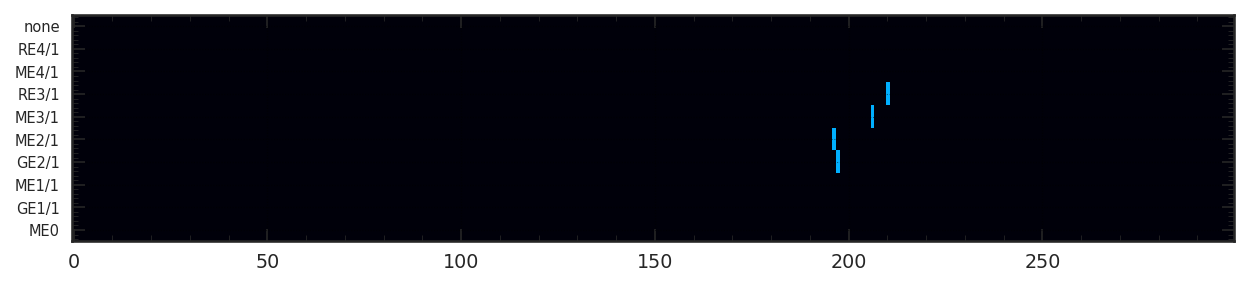

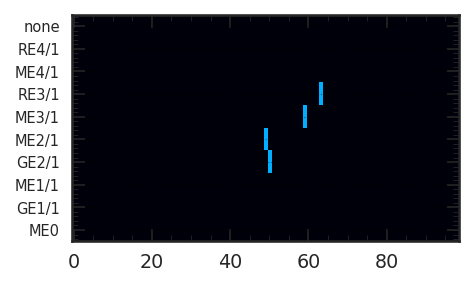

7
[5]
[81]


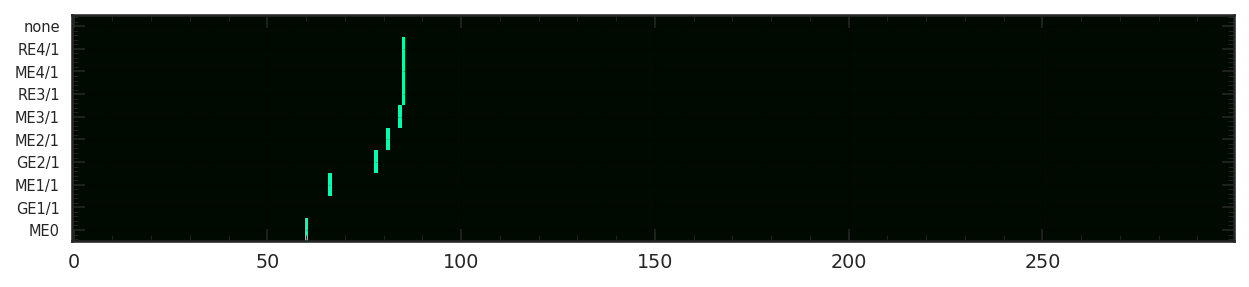

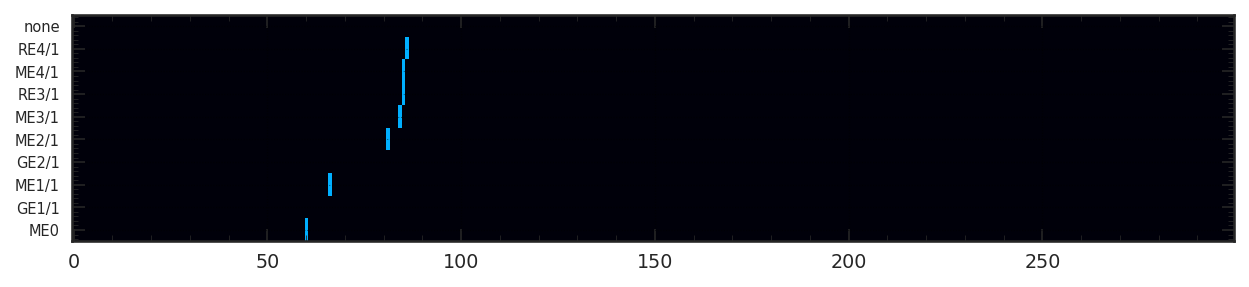

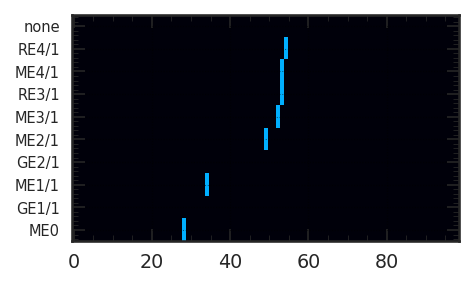

8
[9]
[251]


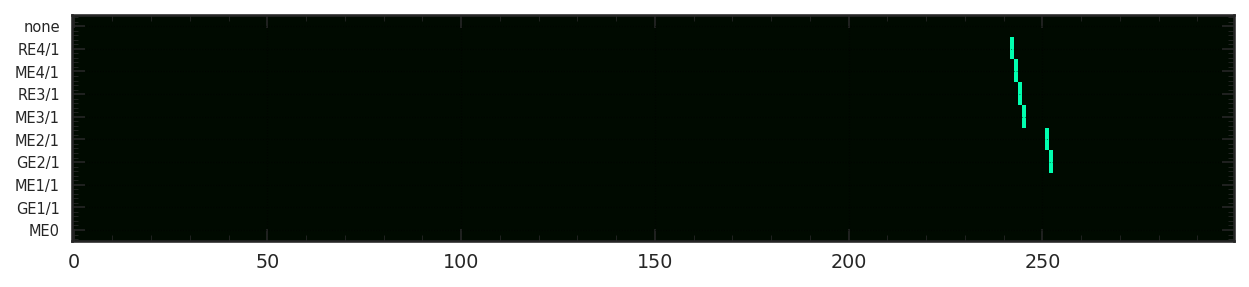

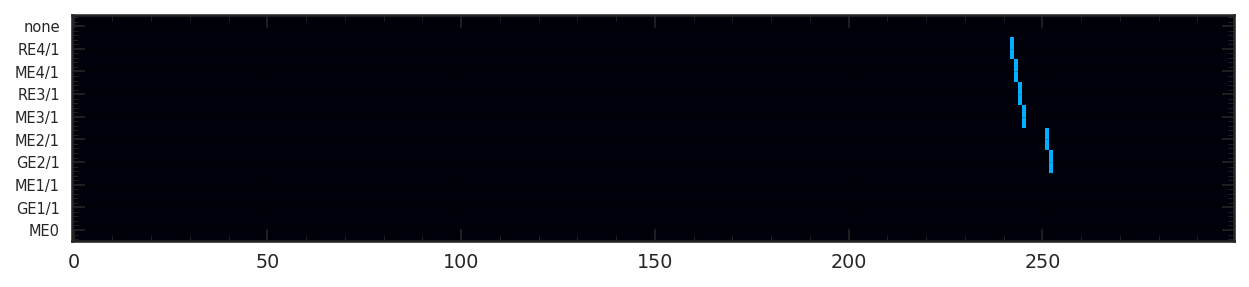

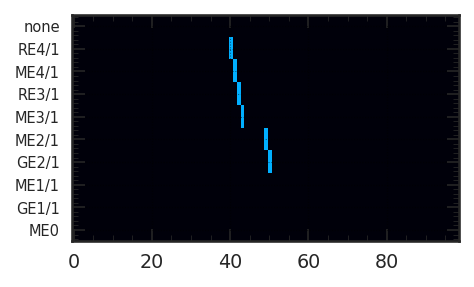

9
[19]
[95]


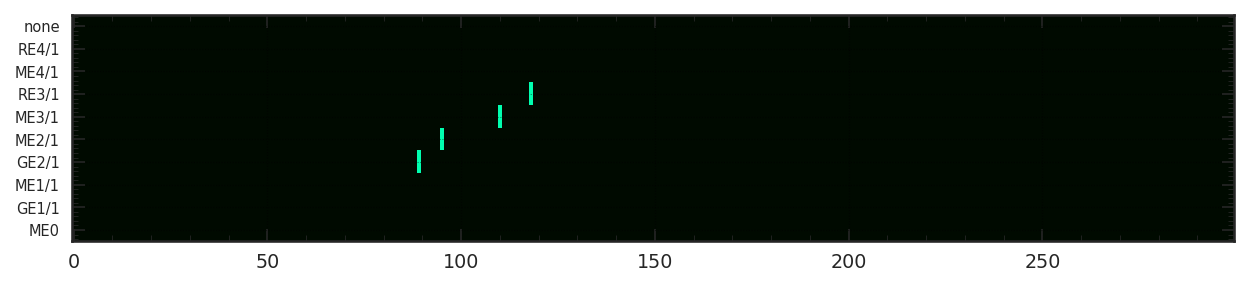

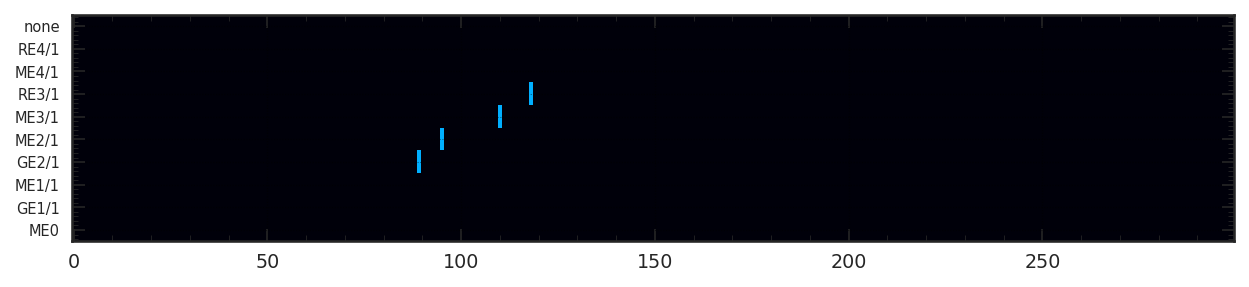

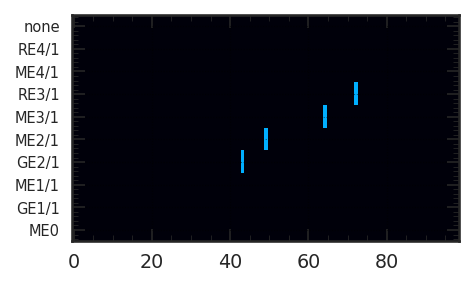

In [41]:
if do_annotations:
  with h5py.File(annotations_filename, 'r') as f:
    images_x = f['images_x']
    images_y = f['images_y']
    images_c = f['images_c']

    for ievt in range(10):
      print(ievt)
      print(single_val(np.nonzero(images_y[ievt])))
      print(images_c[ievt])
      display_image(zone, images_gt[ievt], cmap=green_hot)
      display_image(zone, images[ievt])
      display_image(zone, images_x[ievt], figsize=(3.333,2))

14
[12]
[81]


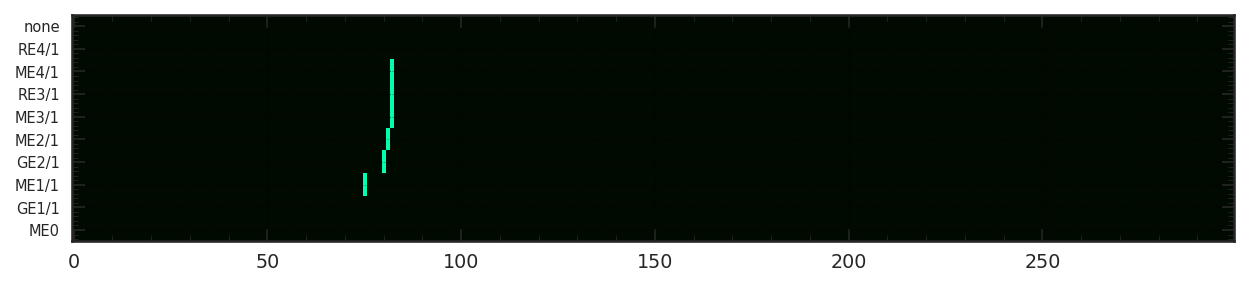

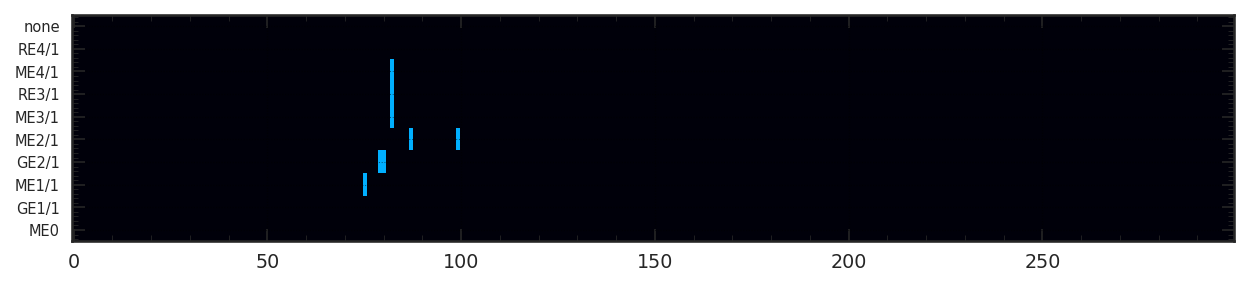

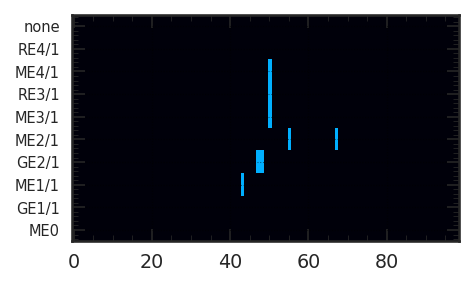

75
[12]
[265]


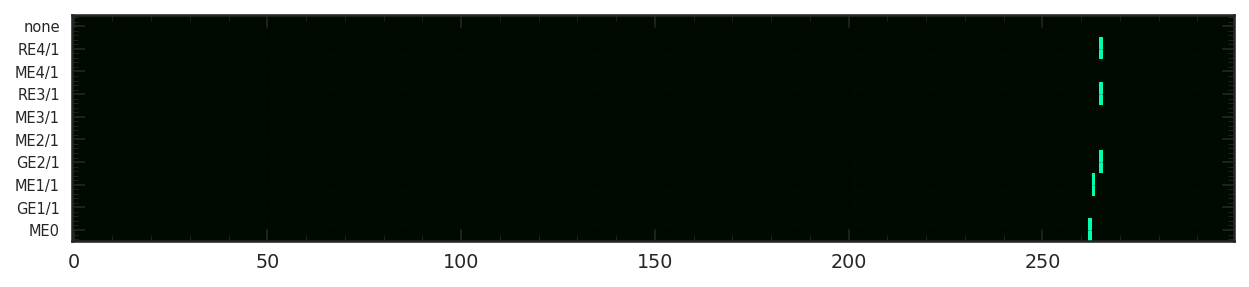

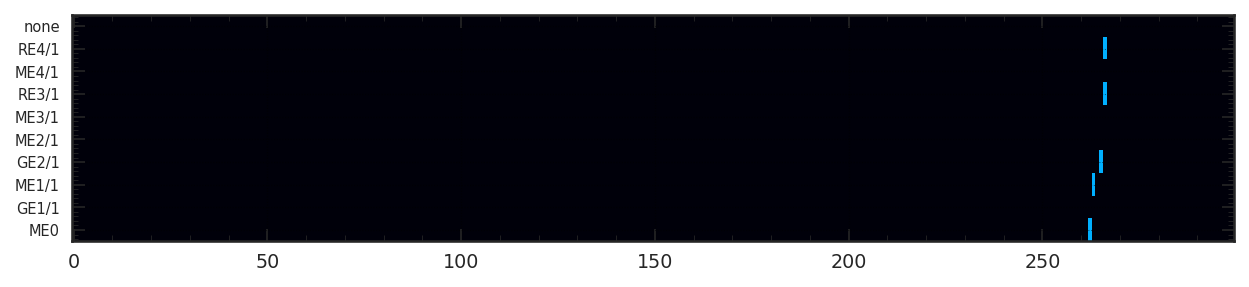

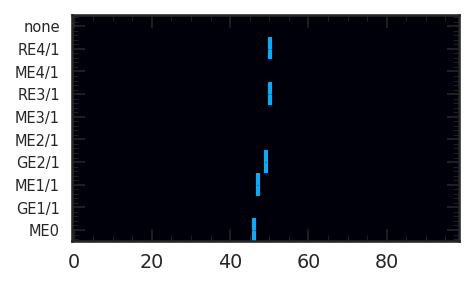

186
[12]
[108]


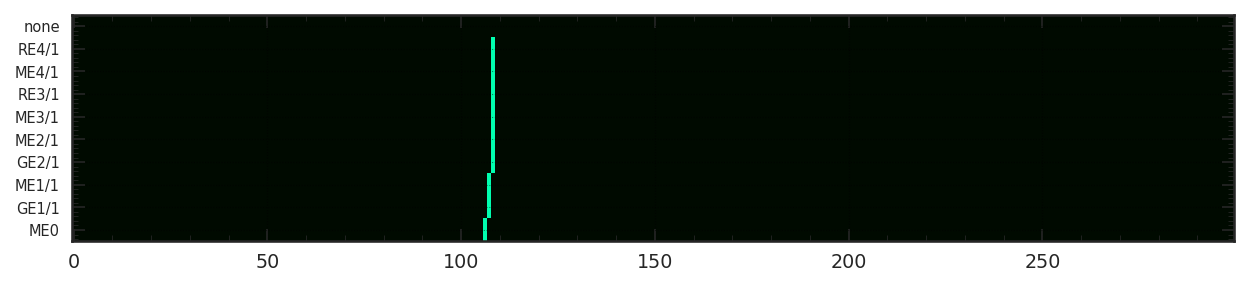

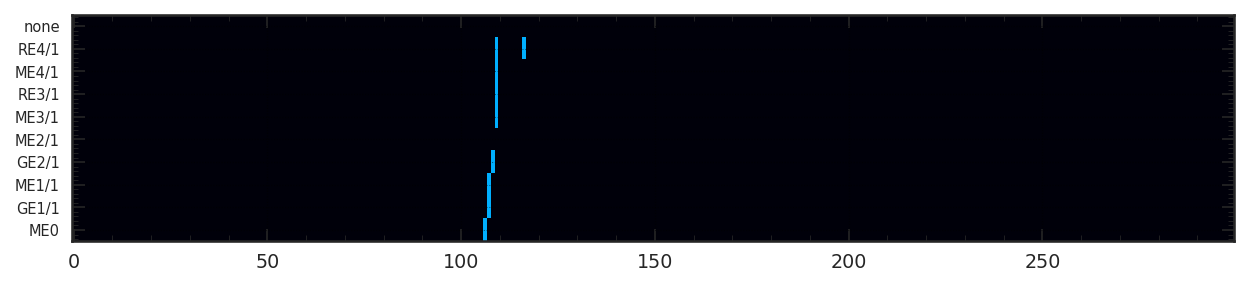

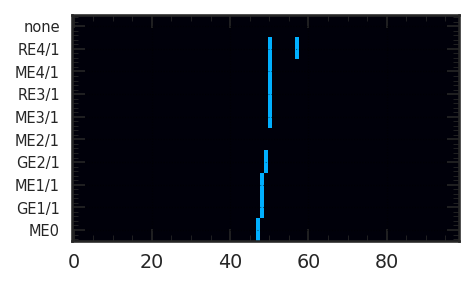

196
[12]
[222]


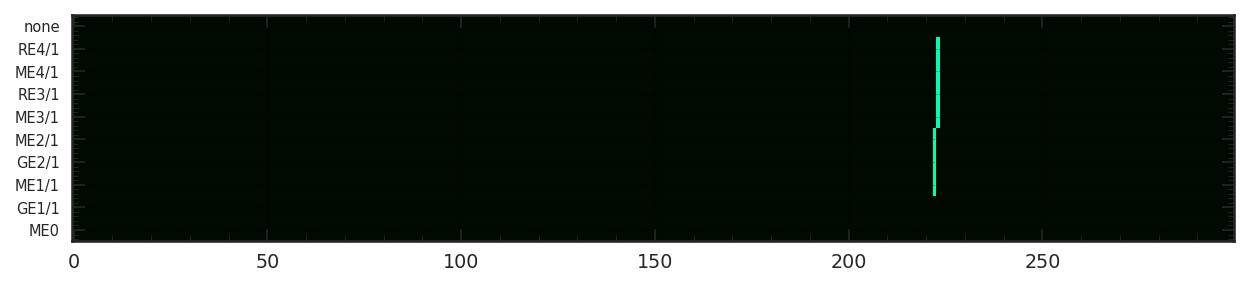

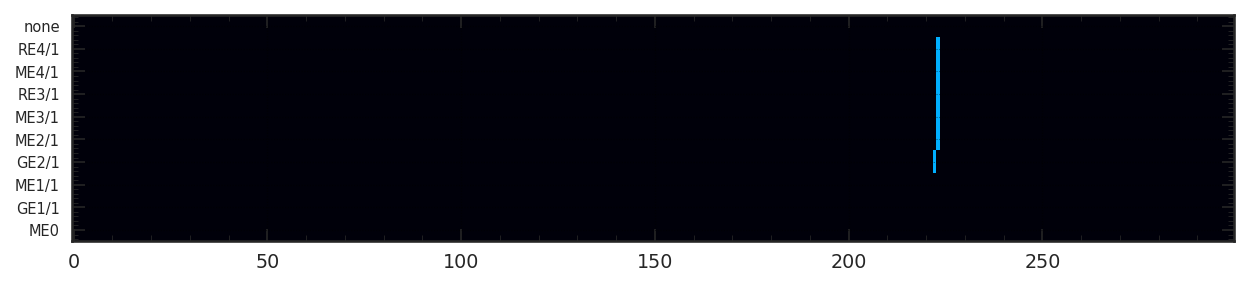

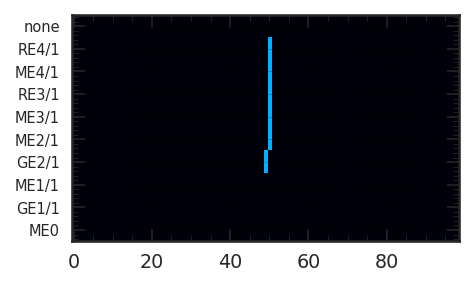

232
[12]
[199]


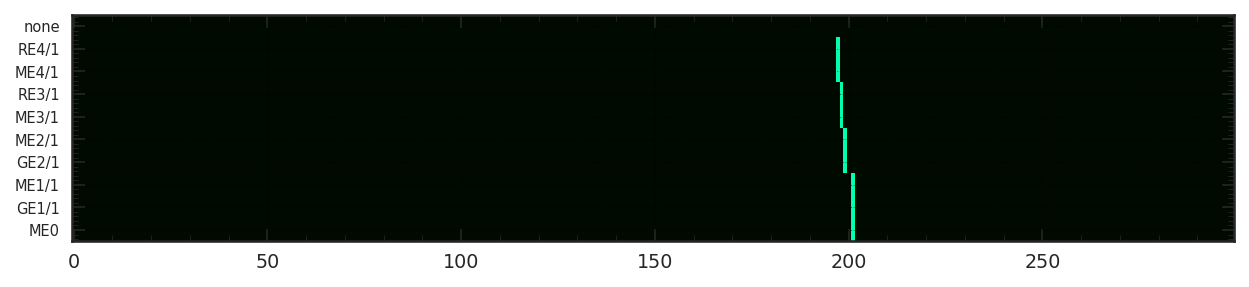

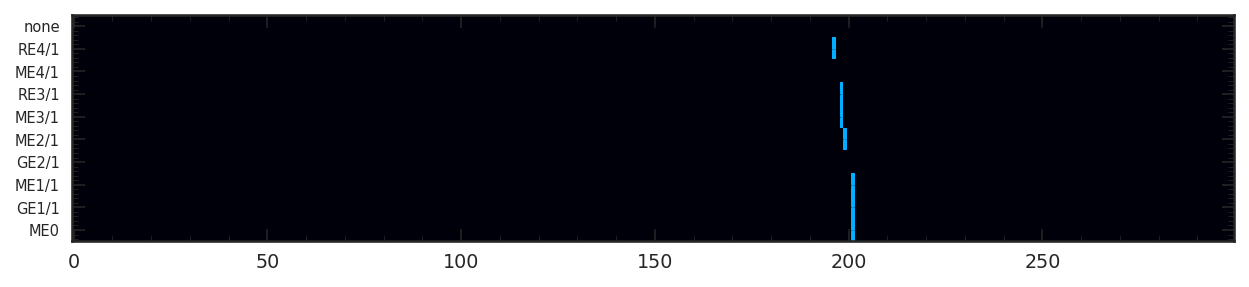

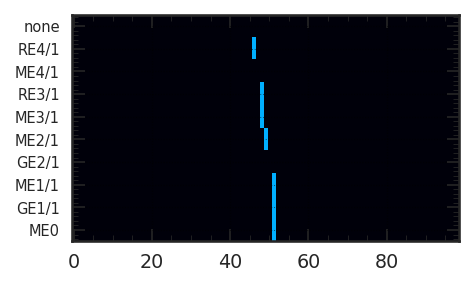

291
[12]
[270]


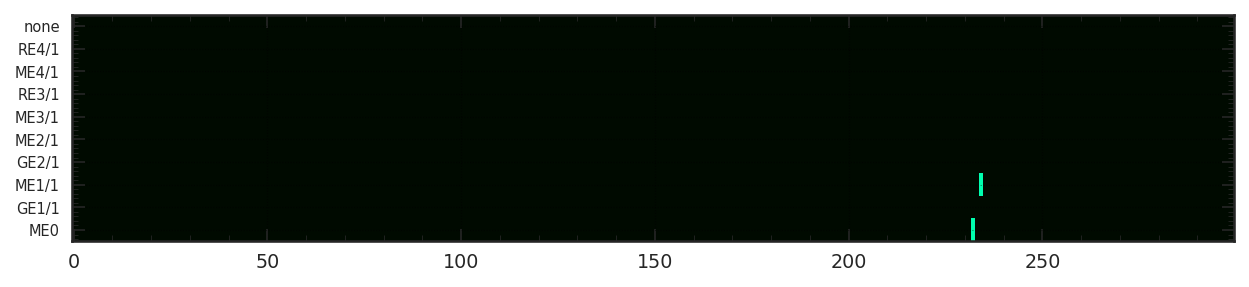

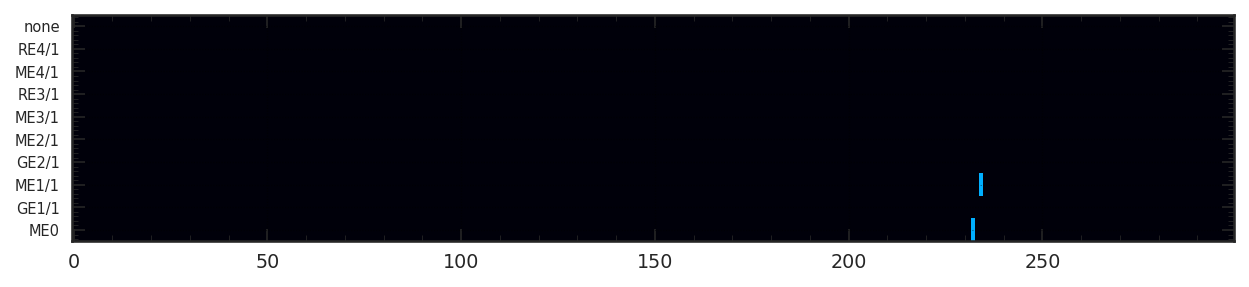

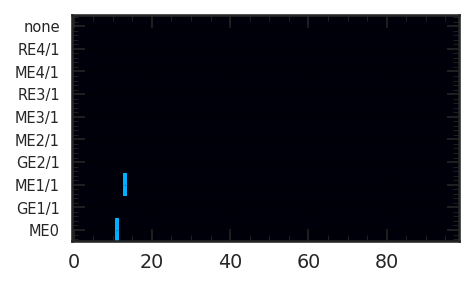

In [42]:
if do_annotations:
  with h5py.File(annotations_filename, 'r') as f:
    images_x = f['images_x']
    images_y = f['images_y']
    images_c = f['images_c']

    for ievt in range(300):
      if images_y[ievt][(2 * num_par_cols + 2)] == 0:
        continue
      print(ievt)
      print(single_val(np.nonzero(images_y[ievt])))
      print(images_c[ievt])
      display_image(zone, images_gt[ievt], cmap=green_hot)
      display_image(zone, images[ievt])
      display_image(zone, images_x[ievt], figsize=(3.333,2))